In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# VAE Class

In [3]:
class VAE:
    def __init__(self, input_dim, hidden_dims, latent_dim, data_size=1):
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.latent_dim = latent_dim

        # Encoder weights and biases
        self.encoder_weights = []
        self.encoder_biases = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            # self.encoder_weights.append(np.random.randn(prev_dim, h_dim) * 0.01)
            self.encoder_weights.append(np.random.randn(prev_dim, h_dim) * 0.01)
            self.encoder_biases.append(np.zeros((1, h_dim)))
            prev_dim = h_dim

        # Latent space parameters
        # self.W_mu = np.random.randn(prev_dim, latent_dim) * 0.01
        self.W_mu = np.random.randn(prev_dim, latent_dim) * 0.01
        self.b_mu = np.zeros((1, latent_dim))
        # self.W_logvar = np.random.randn(prev_dim, latent_dim) * 0.01
        self.W_logvar = np.random.randn(prev_dim, latent_dim) * 0.01
        self.b_logvar = np.zeros((1, latent_dim))

        # Decoder weights and biases
        self.decoder_weights = []
        self.decoder_biases = []
        hidden_dims_reverse = list(reversed(hidden_dims))
        prev_dim = latent_dim
        for h_dim in hidden_dims_reverse:
            # self.decoder_weights.append(np.random.randn(prev_dim, h_dim) * 0.01)
            self.decoder_weights.append(np.random.randn(prev_dim, h_dim) * 0.01)
            self.decoder_biases.append(np.zeros((1, h_dim)))
            prev_dim = h_dim

        # Final decoder layer
        self.W_out = np.random.randn(prev_dim, input_dim) * 0.01
        self.b_out = np.zeros((1, input_dim))

    # Activation functions
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self,x):
        s = self.sigmoid(x)
        return s * (1 - s)

    def softplus(self,x):
        return np.log10(1 + np.exp(x))

    def softplus_derivative(self,x):
        return 1 / (1 + np.exp(-x))

    def relu(self,x):
        return np.maximum(0, x)

    def relu_derivative(self,x):
        return (x > 0).astype(float)

    # Loss functions
    def binary_cross_entropy(self,y_pred, y_true):
        return -np.sum(y_true * np.log(y_pred ) + (1 - y_true) * np.log(1 - y_pred))

    def binary_cross_entropy_derivative(self,y_pred, y_true):
        # return (y_pred - y_true) / (y_pred * (1 - y_pred))
        return -y_true /y_pred + (1-y_true)/(1-y_pred)

    def kl_divergence(self,mu, logvar):
        return -0.5 * np.sum(1 + logvar - np.square(mu) - (logvar))

    # Reparameterization trick
    def reparameterize(self,mu, logvar):
        std = np.exp(0.5 * logvar)
        self.eps = np.random.randn(*mu.shape)
        return mu + self.eps * std

    def forward(self, x):
        # Encoder forward pass
        h = x
        encoder_activations = []
        for W, b in zip(self.encoder_weights, self.encoder_biases):
            h = self.relu(np.dot(h, W) + b)
            encoder_activations.append(h)
        if not encoder_activations:
            encoder_activations.append(h)

        # Latent space
        mu = np.dot(h, self.W_mu) + self.b_mu
        logvar = np.dot(h, self.W_logvar) + self.b_logvar
        z = self.reparameterize(mu, self.relu(logvar))

        # Decoder forward pass
        h = z
        decoder_activations = []
        # print(self.decoder_weights, self.decoder_biases)
        for W, b in zip(self.decoder_weights, self.decoder_biases):
            h = self.relu(np.dot(h, W) + b)
            decoder_activations.append(h)
        if not decoder_activations:
            decoder_activations.append(h)
        x_recon = self.sigmoid(np.dot(h, self.W_out) + self.b_out)

        return x_recon, mu, logvar, z, encoder_activations, decoder_activations

    def only_forward(self,x,w_enc, b_enc,w_mu,b_mu, w_var, b_var, w_dec, b_dec):
        # Encoder forward pass
        h = x
        encoder_activations = []
        for W, b in zip(self.encoder_weights, self.encoder_biases):
            h = self.relu(np.dot(h, W) + b)
            encoder_activations.append(h)
        if not encoder_activations:
            encoder_activations.append(h)

        # Latent space
        mu = np.dot(h, self.W_mu) + self.b_mu
        logvar = np.dot(h, self.W_logvar) + self.b_logvar
        z = self.reparameterize(mu, self.relu(logvar))

        # Decoder forward pass
        h = z
        decoder_activations = []
        # print(self.decoder_weights, self.decoder_biases)
        for W, b in zip(self.decoder_weights, self.decoder_biases):
            h = self.relu(np.dot(h, W) + b)
            decoder_activations.append(h)
        if not decoder_activations:
            decoder_activations.append(h)
        x_recon = self.sigmoid(np.dot(h, self.W_out) + self.b_out)

        return x_recon, mu, logvar, z, encoder_activations, decoder_activations

    def backward(self, x, x_recon, mu, logvar, z, encoder_activations, decoder_activations, learning_rate):
        # Gradient of reconstruction loss with respect to x_recon
        d_x_recon = self.binary_cross_entropy_derivative(x_recon, x)

        # Backpropagate through the output layer
        d_h = d_x_recon * (x_recon * (1 - x_recon))  # Sigmoid derivative

        # Update final decoder layer
        self.W_out -= learning_rate * np.matmul(decoder_activations[-1].T, d_h)
        self.b_out -= learning_rate * np.sum(d_h, axis=0, keepdims=True)

        d_h = d_h = np.matmul(d_h, self.W_out.T)

        # Update decoder hidden layers
        for i in reversed(range(len(self.decoder_weights))):
            # d_h = np.dot(d_h, self.decoder_weights[i].T) * (decoder_activations[i] > 0).astype(float)  # ReLU derivative
            self.decoder_weights[i] -= learning_rate * np.matmul(decoder_activations[i - 1].T, d_h) if i > 0 else learning_rate * np.matmul(z.T, d_h)
            self.decoder_biases[i] -= learning_rate * np.sum(d_h, axis=0, keepdims=True)
            d_h = np.matmul(d_h, self.decoder_weights[i].T) * self.relu_derivative(decoder_activations[i-1]) if i>0 else np.matmul(d_h, self.decoder_weights[i].T)

        # Gradients for latent space
        # d_z = np.dot(d_h, self.decoder_weights[0].T)  # Backprop into latent space

        # Backpropagate through the reparameterization trick
        d_mu = d_h
        d_logvar = 0.5 * d_h * self.eps * np.exp(0.5 * logvar)

        # Update latent space weights and biases
        self.W_mu -= learning_rate * np.matmul(encoder_activations[-1].T, d_mu)
        self.b_mu -= learning_rate * np.sum(d_mu, axis=0, keepdims=True)

        self.W_logvar -= learning_rate * np.matmul(encoder_activations[-1].T, d_logvar)
        self.b_logvar -= learning_rate * np.sum(d_logvar, axis=0, keepdims=True)

        # self.W_mu -= learning_rate * (np.dot(encoder_activations[-1].T, d_h) + np.dot(encoder_activations[-1].T, mu))
        # grad_b_mu = (np.sum(d_h, axis=1, keepdims=True) + mu)
        # for mu_elem in grad_b_mu:
        #     self.b_mu -= learning_rate * mu_elem

        # self.W_logvar -= learning_rate * np.dot(encoder_activations[-1].T,(0.5 * d_h * self.eps * np.exp(0.5 * logvar)))
        # self.b_logvar -= learning_rate * (np.sum(0.5 * d_h * self.eps * np.exp(0.5 * logvar), axis=0, keepdims=True))

        # d_mu = d_h + mu
        # d_logvar = 0.5 * d_h * self.eps * np.exp(0.5 * logvar) * self.relu_derivative(logvar)

        # Update encoder layers
        d_h = np.matmul(d_mu, self.W_mu.T) + np.matmul(d_logvar, self.W_logvar.T)
        for i in reversed(range(len(self.encoder_weights))):
            self.encoder_weights[i] -= learning_rate * np.matmul(encoder_activations[i - 1].T, d_h) if i > 0 else learning_rate * np.matmul(x.T, d_h)
            self.encoder_biases[i] -= learning_rate * np.sum(d_h, axis=0, keepdims=True)
            d_h = np.matmul(d_h, self.encoder_weights[i].T) * self.relu_derivative(encoder_activations[i-1]) if i>0 else np.matmul(d_h, self.encoder_weights[i].T)

    def train(self, x, valid_data, epochs, learning_rate, doTest = True):
        history_loss = []
        preTrain_data = x.copy()
        print(f'Data to train: {x}')
        print(f'Valid Data: {valid_data}')

        # if len(valid_data.shape) == 3:
        for epoch in range(epochs):
            total_loss = 0
            kl_loss = 0
            recon_loss = 0
            # for idx,sample in enumerate(x):  # Iterate through each column
            #     # print(f'Iter {idx}\tTraining of data {sample} based on data {valid_data[idx]}')
            #     curr_data = sample.reshape(1, -1)
            #     # print(f'Reshaped data: {curr_data}')
            #     x_recon, mu, logvar, z, encoder_activations, decoder_activations = self.forward(curr_data)
            #     # print(f'Current reconstruction: {x_recon}')

            #     # Compute losses
            #     recon_loss_sample = self.binary_cross_entropy(x_recon, valid_data[idx])
            #     kl_loss_sample = self.kl_divergence(mu, logvar)
            #     loss = recon_loss_sample + kl_loss_sample

            #     # Backward pass
            #     self.backward(valid_data[idx], x_recon, mu, logvar, z, encoder_activations, decoder_activations, learning_rate)

            #     # Accumulate losses
            #     total_loss += loss
            #     kl_loss += kl_loss_sample
            #     recon_loss += recon_loss_sample

            # print(f'Iter {idx}\tTraining of data {sample} based on data {valid_data[idx]}')
            curr_data = x.copy()
            # print(f'Reshaped data: {curr_data}')
            x_recon, mu, logvar, z, encoder_activations, decoder_activations = self.forward(curr_data)
            # print(f'Current reconstruction: {x_recon}')

            # Compute losses
            recon_loss_sample = self.binary_cross_entropy(x_recon, valid_data)
            kl_loss_sample = self.kl_divergence(mu, logvar)
            beta = 0.1
            loss = recon_loss_sample + beta * kl_loss_sample

            # Backward pass
            self.backward(valid_data, x_recon, mu, logvar, z, encoder_activations, decoder_activations, learning_rate)

            # Accumulate losses
            total_loss += loss
            kl_loss += kl_loss_sample
            recon_loss += recon_loss_sample

            # Loss history
            curr_avg_loss = total_loss/x.shape[0]
            history_loss.append(curr_avg_loss)

            # Check error and break
            if total_loss < (2**(-8)):
                break

            # Print epoch details
            if (epoch + 1) % 1 == 0 or epoch == 0:
                # print(f"Epoch {epoch + 1}/{epochs} - Total Loss: {total_loss:.4f}, Recon Loss: {recon_loss:.4f}, KL Loss: {kl_loss:.4f}, Average Loss: {curr_avg_loss:.4f}",end='\n')
                print(f"Epoch {epoch + 1}/{epochs} - Total Loss: {total_loss:.4f}, Recon Loss: {recon_loss:.4f}, KL Loss: {kl_loss:.4f}",end='\n')
        # else:
        #     for epoch in range(epochs):
        #         total_loss = 0
        #         kl_loss = 0
        #         recon_loss = 0
        #         for idx,sample in enumerate(x):  # Iterate through each column
        #             # print(f'Iter {idx}\tTraining of data {sample} based on data {valid_data[idx]}')
        #             curr_data = sample.reshape(1, -1)
        #             # print(f'Reshaped data: {x}')
        #             x_recon, mu, logvar, z, encoder_activations, decoder_activations = self.forward(curr_data)

        #             # Compute losses
        #             recon_loss_sample = self.binary_cross_entropy(x_recon, valid_data)
        #             kl_loss_sample = self.kl_divergence(mu, logvar)
        #             loss = recon_loss_sample + kl_loss_sample

        #             # Backward pass
        #             self.backward(valid_data, x_recon, mu, logvar, z, encoder_activations, decoder_activations, learning_rate)

        #             # Accumulate losses
        #             total_loss += loss
        #             kl_loss += kl_loss_sample
        #             recon_loss += recon_loss_sample

        #         # Loss history
        #         curr_avg_loss = total_loss/x.shape[0]
        #         history_loss.append(curr_avg_loss)

        #         # Check error and break
        #         if total_loss < (2**(-8)):
        #             break

        #         # Print epoch details
        #         if (epoch + 1) % 1 == 0 or epoch == 0:
        #             # print(f"Epoch {epoch + 1}/{epochs} - Total Loss: {total_loss:.4f}, Recon Loss: {recon_loss:.4f}, KL Loss: {kl_loss:.4f}, Average Loss: {curr_avg_loss:.4f}",end='\n')
        #             print(f"Epoch {epoch + 1}/{epochs} - Total Loss: {total_loss:.4f}, Recon Loss: {recon_loss:.4f}, KL Loss: {kl_loss:.4f}",end='\n')

        print(f'This Data: {x}')
        print(f'Has finished trained based on the following Valid Data:')
        check_valid_data = []
        for i in valid_data: print(i); check_valid_data.append(i)
        if doTest:
            # Evaluate: Reconstruct the input data
            reconstructed = []
            latent_val = []
            for x in preTrain_data:
                x = x.reshape(1, -1)
                x_recon, _, _, curr_latent, _, _ = self.forward(x)
                reconstructed.append(x_recon)
                latent_val.append(curr_latent)
            reconstructed = np.vstack(reconstructed)

            print(f"\nOriginal Data: (Shape: {preTrain_data.shape})")
            print(preTrain_data)

            print(f"\nReconstructed Data: (Shape: {reconstructed.shape})")
            print(np.round(reconstructed))  # Rounded for binary output

            # mtrx_true_data = np.tile(valid_data[0], (x.shape[0],1))
            # if ((np.round(reconstructed)==mtrx_true_data).all()): print('[INFO] Reconstruction success')
            # else: print('[ERROR] Reconstruction Failed')

            if ((np.round(reconstructed)==check_valid_data).all()): print('[INFO] Reconstruction success')
            else: print('[ERROR] Reconstruction Failed')

            plt.figure(figsize=(10,9))
            plt.plot(history_loss,label="Loss History")
            plt.legend()
            plt.xlabel("Epoch")
            plt.ylabel("Error")
            plt.title('Total History over Epochs')
            plt.show()

        # After training, return latent value
        return latent_val



    def get_train_param(self):
        return self.encoder_weights,self.encoder_biases, self.W_mu,self.b_mu, self.W_logvar,self.b_logvar, self.decoder_weights,self.decoder_biases, self.W_out, self.b_out

# Testing VAE on X and O data

Data to train: [[1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [0. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 0. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 0. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 0. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 1. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 0. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 0. 0. 1. 0. 1.]]
Valid Data: [[1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]]
Epoch 1/1000 - Total Loss: 74.2237, Recon Loss: 74.8237, KL Loss: -5.9994
Epoch 2/1000 - Total Loss: 73.6597, Recon Loss: 74.2597, KL Loss: -5.9994
Epoch 3/1000 - Total Loss: 73.0908, Recon Loss: 73.6906, KL Loss: -5.9988
Epoch 4/1000 - Total Loss: 72

Epoch 634/1000 - Total Loss: 14.7585, Recon Loss: 1.7747, KL Loss: 129.8384
Epoch 635/1000 - Total Loss: 15.0021, Recon Loss: 2.0236, KL Loss: 129.7846
Epoch 636/1000 - Total Loss: 14.7119, Recon Loss: 1.7178, KL Loss: 129.9408
Epoch 637/1000 - Total Loss: 14.6833, Recon Loss: 1.6848, KL Loss: 129.9854
Epoch 638/1000 - Total Loss: 15.0307, Recon Loss: 2.0178, KL Loss: 130.1297
Epoch 639/1000 - Total Loss: 14.6297, Recon Loss: 1.5988, KL Loss: 130.3095
Epoch 640/1000 - Total Loss: 15.7399, Recon Loss: 2.7040, KL Loss: 130.3586
Epoch 641/1000 - Total Loss: 14.7121, Recon Loss: 1.6035, KL Loss: 131.0867
Epoch 642/1000 - Total Loss: 14.6400, Recon Loss: 1.5314, KL Loss: 131.0854
Epoch 643/1000 - Total Loss: 14.6821, Recon Loss: 1.5698, KL Loss: 131.1225
Epoch 644/1000 - Total Loss: 14.9914, Recon Loss: 1.8712, KL Loss: 131.2023
Epoch 645/1000 - Total Loss: 14.7623, Recon Loss: 1.6495, KL Loss: 131.1273
Epoch 646/1000 - Total Loss: 14.7822, Recon Loss: 1.6642, KL Loss: 131.1797
Epoch 647/10

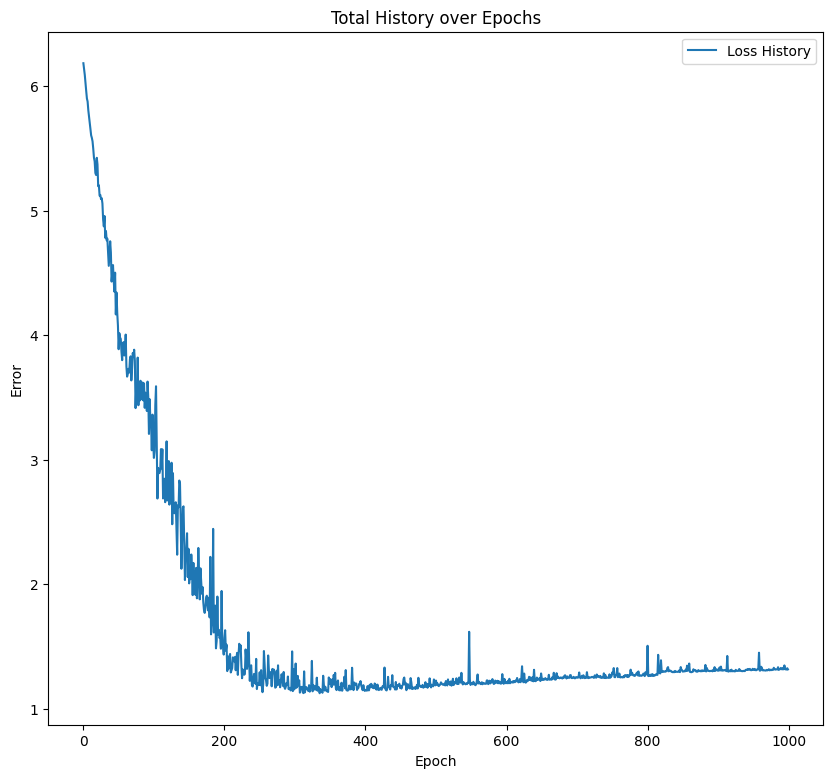

In [57]:
input_dim = 9  # Number of input features
latent_dim = 1  # Number of latent dimensions
hidden_dims = []

vae = VAE(input_dim=input_dim, hidden_dims=hidden_dims, latent_dim=latent_dim)

# Create dataset
testData = np.zeros((12,9))
testData[0,:] = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]]).reshape(1,9).flatten()
testData[1,:] = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 1]]).reshape(1,9).flatten()
testData[2,:] = np.array([[1, 0, 1], [1, 0, 1], [1, 1, 1]]).reshape(1,9).flatten()
testData[3,:] = np.array([[1, 1, 0], [1, 0, 1], [1, 1, 1]]).reshape(1,9).flatten()
testData[4,:] = np.array([[1, 1, 1], [0, 0, 1], [1, 1, 1]]).reshape(1,9).flatten()
testData[5,:] = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]).reshape(1,9).flatten()

testData[6,:] = np.array([[1, 0, 1], [0, 1, 0], [1, 0, 1]]).reshape(1,9).flatten()
testData[7,:] = np.array([[0, 0, 1], [0, 1, 0], [1, 0, 1]]).reshape(1,9).flatten()
testData[8,:] = np.array([[1, 1, 1], [0, 1, 0], [1, 0, 1]]).reshape(1,9).flatten()
testData[9,:] = np.array([[1, 0, 0], [0, 1, 0], [1, 0, 1]]).reshape(1,9).flatten()
testData[10,:] = np.array([[1, 0, 1], [1, 1, 0], [1, 0, 1]]).reshape(1,9).flatten()
testData[11,:] = np.array([[1, 0, 1], [0, 0, 0], [1, 0, 1]]).reshape(1,9).flatten()

valid_data = np.zeros((12,9))
valid_data[:6,:] = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]]).reshape(1,9).flatten()
valid_data[6:,:] = np.array([[1, 0, 1], [0, 1, 0], [1, 0, 1]]).reshape(1,9).flatten()

# data = testData

# label_train_simple = np.concatenate((valid_data1, valid_data2), axis=0)
# data_train_simple = np.concatenate((data, data), axis=0)

# Train the VAE
epochs = 1000
learning_rate = 0.005
latent_val = vae.train(testData, valid_data, epochs, learning_rate)

# Wafermap Data Learning

## Reading Dataset of Wafermap

In [4]:
import cv2
df=pd.read_pickle("WM811K.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   dieSize         811457 non-null  float64
 1   failureType     811457 non-null  object 
 2   lotName         811457 non-null  object 
 3   trainTestLabel  811457 non-null  object 
 4   waferIndex      811457 non-null  float64
 5   waferMap        811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [5]:
# Function to scale up image
def upscale_images(np_arr, max_shape):
    return cv2.resize(np_arr, (max_shape[1],max_shape[0]), interpolation=cv2.INTER_CUBIC)

def sizeLimit_df(old_df, max_shape, doLimit=False):
  if doLimit: return old_df[old_df['waferMap'].apply(lambda x: x.shape[0] <= max_shape[0] and x.shape[1] <= max_shape[1])]
  else: return old_df

# Function to display wafer
def print_image(np_arr):
    if np.max(np_arr) == 2: cmap = mcolors.ListedColormap(['black', 'grey', 'white'])
    else: cmap = mcolors.ListedColormap(['black', 'grey'])
    # Create an image of the array
    plt.imshow(np_arr, cmap=cmap, interpolation='nearest')

    # Optionally, remove axis labels
    plt.axis('off')

    # Show the plot
    plt.show()

## Get Training Data

In [6]:
max_shape = (40,40)
target_shape = (32,32)
train_max_row = 20 # Maximum data for training

strClass_trainTestLaebl_df = df[df['trainTestLabel'].apply(lambda x: isinstance(x, str))]
limited_df = sizeLimit_df(strClass_trainTestLaebl_df,max_shape,True)
training_df = limited_df[limited_df['trainTestLabel'] == 'Training']

bad_wafer_df = training_df[ (training_df['failureType'] != 'none')]
good_wafer_df = training_df[ (training_df['failureType'] == 'none')]

# Function to filter very bad data
def filter_condition(np_arr, wafer_type):
    count_0 = np.sum(np_arr == 0)  # Count occurrences of 1
    count_1 = np.sum(np_arr == 1)  # Count occurrences of 1
    count_2 = np.sum(np_arr == 2)  # Count occurrences of 2
    if wafer_type == 'bad': return (count_2 > 0.05 * count_1) & (count_0 < count_1)  # Check if count of 2 is less than 20% of count of 1
    else: return (count_2 < 0.05 * count_1) & (count_0 < count_1)  # Check if count of 2 is less than 20% of count of 1


bad_wafer_df = bad_wafer_df[bad_wafer_df['waferMap'].apply(lambda x: filter_condition(x, 'bad'))]
good_wafer_df = good_wafer_df[good_wafer_df['waferMap'].apply(lambda x: filter_condition(x, 'good'))]

# Label data for bad wafer
maxSize_bad_wafer = bad_wafer_df[(bad_wafer_df['waferMap'].apply(lambda x: x.shape == (35,36)))]
mtrx_label_bad_wafer = np.stack(maxSize_bad_wafer['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
mtrx_label_bad_wafer[(mtrx_label_bad_wafer == 1) | (mtrx_label_bad_wafer > 2)] = 2
base_bad_valid = np.array(mtrx_label_bad_wafer[0])
label_bad_wafer = np.tile(base_bad_valid,(train_max_row,1))

# Label data for good wafer
maxSize_good_wafer = good_wafer_df[(good_wafer_df['waferMap'].apply(lambda x: x.shape == (35,37)))]
mtrx_label_good_wafer = np.stack(maxSize_good_wafer['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
mtrx_label_good_wafer[mtrx_label_good_wafer >1] = 1
base_good_valid = np.array(mtrx_label_good_wafer[0])
label_good_wafer = np.tile(base_good_valid,(train_max_row,1))

# Maximum Data for Training
# print(bad_wafer_df.shape, good_wafer_df.shape)
max_training_good = good_wafer_df.shape[0]
max_training_bad = bad_wafer_df.shape[0]
print(max_training_good, max_training_bad)
bad_wafer_df = bad_wafer_df[:train_max_row]
good_wafer_df = good_wafer_df[:train_max_row]

# Scale all image to asme dimension then flatten it to single row
data_bad_wafer = np.stack(bad_wafer_df['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
data_bad_wafer[data_bad_wafer>2] = 2

data_good_wafer = np.stack(good_wafer_df['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
data_good_wafer[data_good_wafer>2] = 2

label_train = np.concatenate((label_bad_wafer, label_good_wafer), axis=0)
data_train = np.concatenate((data_bad_wafer, data_good_wafer), axis=0)

label_train = np.where(label_train == 0, 0 , np.where(label_train == 1, 0.5, 1))
data_train = np.where(data_train == 0, 0 , np.where(data_train == 1, 0.5, 1))

print(label_train.shape)
print(data_train.shape)


106 8003
(40, 1024)
(40, 1024)


In [7]:
# label_train = np.concatenate((label_good_wafer,label_bad_wafer), axis=0)
# data_train = np.concatenate((data_good_wafer, data_bad_wafer), axis=0)
label_train = np.concatenate((label_bad_wafer, label_good_wafer), axis=0)
data_train = np.concatenate((data_bad_wafer, data_good_wafer), axis=0)

label_train = np.where(label_train == 0, 0 , np.where(label_train == 1, 0.5, 1))
data_train = np.where(data_train == 0, 0 , np.where(data_train == 1, 0.5, 1))

print(label_train.shape)
print(data_train.shape)

(40, 1024)
(40, 1024)


#### Extra Testing

Unique Shapes (from smallest to largest):
Shape: (26, 26), Area: 676, Count: 20


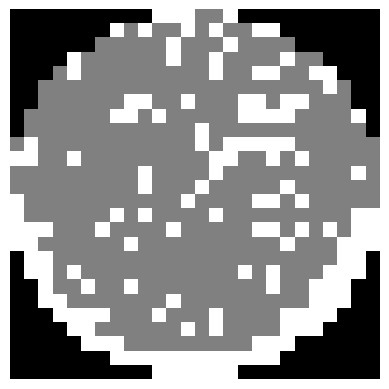

In [62]:
# Extract shapes and count occurrences
def filter_condition(np_arr):
    count_0 = np.sum(np_arr == 0)  # Count occurrences of 1
    count_1 = np.sum(np_arr == 1)  # Count occurrences of 1
    count_2 = np.sum(np_arr == 2)  # Count occurrences of 2
    return (count_2 > 0.05 * count_1) & (count_0 < count_1)  # Check if count of 2 is less than 20% of count of 1
filtered_df = bad_wafer_df[bad_wafer_df['waferMap'].apply(filter_condition)]
# filtered_df = bad_wafer_df

shape_counts = filtered_df["waferMap"].apply(lambda img: img.shape).value_counts()

# Sort shapes sequentially (smallest to largest by area, then by dimensions)
sorted_shapes = sorted(shape_counts.items(), key=lambda x: (x[0][0] * x[0][1], x[0][0], x[0][1]))

# Print the unique shapes, their area, and counts
print("Unique Shapes (from smallest to largest):")
for shape, count in sorted_shapes:
    area = shape[0] * shape[1]
    print(f"Shape: {shape}, Area: {area}, Count: {count}")
    temp = bad_wafer_df[(bad_wafer_df['waferMap'].apply(lambda x: x.shape == shape))]
    print_image(temp['waferMap'].iloc[0])

Unique Shapes (from smallest to largest):
Shape: (39, 31), Area: 1209, Count: 1


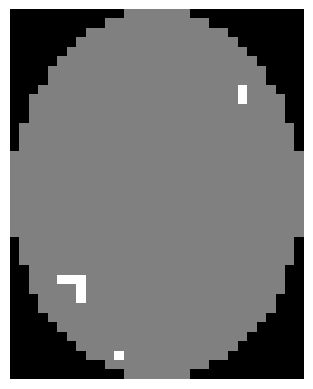

Shape: (35, 37), Area: 1295, Count: 19


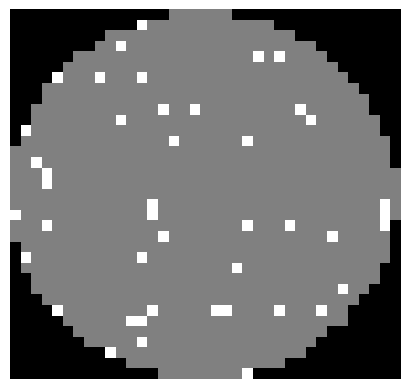

In [63]:
# Extract shapes and count occurrences
def filter_condition(np_arr):
    count_0 = np.sum(np_arr == 0)  # Count occurrences of 1
    count_1 = np.sum(np_arr == 1)  # Count occurrences of 1
    count_2 = np.sum(np_arr == 2)  # Count occurrences of 2
    return (count_2 < 0.05 * count_1) & (count_0 < count_1)  # Check if count of 2 is less than 20% of count of 1
filtered_df = good_wafer_df[good_wafer_df['waferMap'].apply(filter_condition)]

shape_counts = filtered_df["waferMap"].apply(lambda img: img.shape).value_counts()

# Sort shapes sequentially (smallest to largest by area, then by dimensions)
sorted_shapes = sorted(shape_counts.items(), key=lambda x: (x[0][0] * x[0][1], x[0][0], x[0][1]))

# Print the unique shapes, their area, and counts
print("Unique Shapes (from smallest to largest):")
for shape, count in sorted_shapes:
    area = shape[0] * shape[1]
    print(f"Shape: {shape}, Area: {area}, Count: {count}")
    temp = good_wafer_df[(good_wafer_df['waferMap'].apply(lambda x: x.shape == shape))]
    print_image(temp['waferMap'].iloc[0])

## Train Good and Bad Wafer Data

In [26]:
# Initialize the VAE with no hidden layers
input_dim = data_train.shape[1]  # Number of input features
latent_dim = 1  # Number of latent dimensions
hidden_dims = []

vae = VAE(input_dim=input_dim, hidden_dims=hidden_dims, latent_dim=latent_dim)

max_shape = (50,50)
target_shape = (32,32)
train_max_row = 20 # Maximum data for training

strClass_trainTestLaebl_df = df[df['trainTestLabel'].apply(lambda x: isinstance(x, str))]
limited_df = sizeLimit_df(strClass_trainTestLaebl_df,max_shape,True)
training_df = limited_df[limited_df['trainTestLabel'] == 'Training']

bad_wafer_df = training_df[ (training_df['failureType'] != 'none')]
good_wafer_df = training_df[ (training_df['failureType'] == 'none')]

# Function to filter very bad data
def filter_condition(np_arr, wafer_type):
    count_0 = np.sum(np_arr == 0)  # Count occurrences of 1
    count_1 = np.sum(np_arr == 1)  # Count occurrences of 1
    count_2 = np.sum(np_arr == 2)  # Count occurrences of 2
    if wafer_type == 'bad': return (count_2 > 0.9 * count_1) & (count_0 < count_1)  # Check if count of 2 is less than 20% of count of 1
    else: return (count_2 < 0.05 * count_1) & (count_0 < count_1)  # Check if count of 2 is less than 20% of count of 1
    # return True


bad_wafer_df = bad_wafer_df[bad_wafer_df['waferMap'].apply(lambda x: filter_condition(x, 'bad'))]
good_wafer_df = good_wafer_df[good_wafer_df['waferMap'].apply(lambda x: filter_condition(x, 'good'))]
print(bad_wafer_df.shape, good_wafer_df.shape)

# Label data for bad wafer
maxSize_bad_wafer = bad_wafer_df[(bad_wafer_df['waferMap'].apply(lambda x: x.shape == (35,36)))]
mtrx_label_bad_wafer = np.stack(maxSize_bad_wafer['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
mtrx_label_bad_wafer[(mtrx_label_bad_wafer == 1) | (mtrx_label_bad_wafer > 2)] = 2
base_bad_valid = np.array(mtrx_label_bad_wafer[0])


# Label data for good wafer
maxSize_good_wafer = good_wafer_df[(good_wafer_df['waferMap'].apply(lambda x: x.shape == (35,37)))]
mtrx_label_good_wafer = np.stack(maxSize_good_wafer['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
mtrx_label_good_wafer[mtrx_label_good_wafer >1] = 1
base_good_valid = np.array(mtrx_label_good_wafer[0])

(462, 6) (946, 6)


Data to train: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Valid Data: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Epoch 1/200 - Total Loss: 29809.9697, Recon Loss: 29811.9514, KL Loss: -19.8171
Epoch 2/200 - Total Loss: 29788.9091, Recon Loss: 29790.7742, KL Loss: -18.6510
Epoch 3/200 - Total Loss: 29759.1206, Recon Loss: 29759.2351, KL Loss: -1.1452
Epoch 4/200 - Total Loss: 29689.6838, Recon Loss: 29681.4454, KL Loss: 82.3838
Epoch 5/200 - Total Loss: 29415.4027, Recon Loss: 29365.6739, KL Loss: 497.2875
Epoch 6/200 - Total Loss: 28155.3703, Recon Loss: 27904.2428, KL Loss: 2511.2748
Epoch 7/200 - Total Loss: 23962.4015, Recon Loss: 22860.5236, KL Loss: 11018.7798
Epoch 8/200 - Total Loss: 21048.6330, Recon Loss: 18284.8113, KL Loss: 27638.2175
Epoch 9/200 - Tota

Epoch 151/200 - Total Loss: 15739.4191, Recon Loss: 14605.7385, KL Loss: 11336.8065
Epoch 152/200 - Total Loss: 15658.6866, Recon Loss: 14577.4240, KL Loss: 10812.6259
Epoch 153/200 - Total Loss: 15573.6824, Recon Loss: 14522.7078, KL Loss: 10509.7466
Epoch 154/200 - Total Loss: 15657.9935, Recon Loss: 14522.7466, KL Loss: 11352.4682
Epoch 155/200 - Total Loss: 15666.0011, Recon Loss: 14578.3191, KL Loss: 10876.8196
Epoch 156/200 - Total Loss: 15592.5598, Recon Loss: 14512.7217, KL Loss: 10798.3811
Epoch 157/200 - Total Loss: 15648.3170, Recon Loss: 14539.2636, KL Loss: 11090.5342
Epoch 158/200 - Total Loss: 15609.1868, Recon Loss: 14547.6527, KL Loss: 10615.3413
Epoch 159/200 - Total Loss: 15519.4514, Recon Loss: 14408.7065, KL Loss: 11107.4483
Epoch 160/200 - Total Loss: 15665.5557, Recon Loss: 14543.2691, KL Loss: 11222.8661
Epoch 161/200 - Total Loss: 15562.4535, Recon Loss: 14514.7865, KL Loss: 10476.6699
Epoch 162/200 - Total Loss: 15769.4916, Recon Loss: 14536.9022, KL Loss: 123

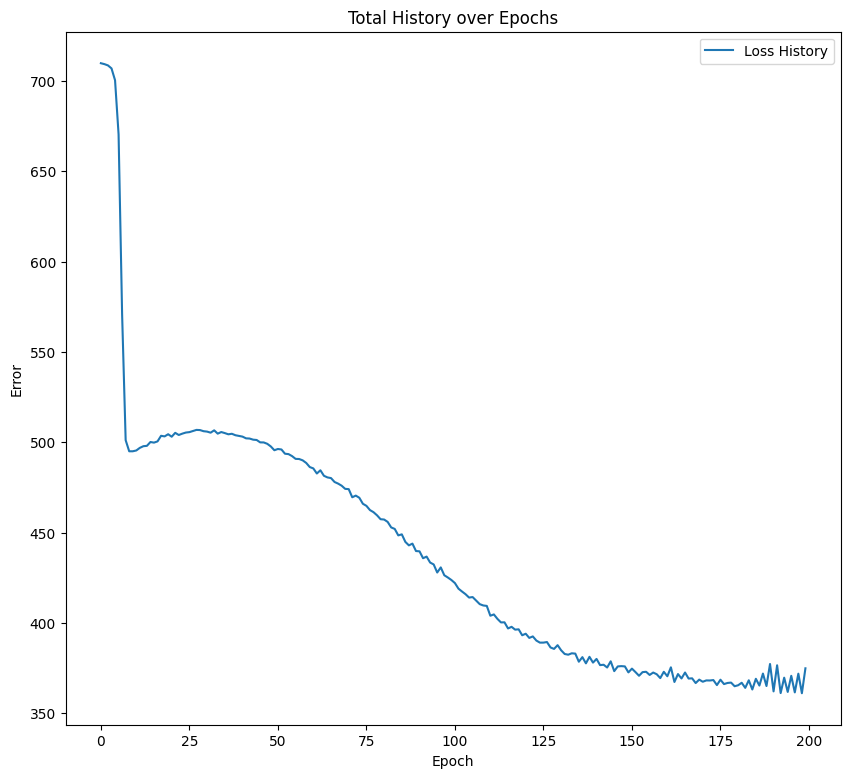

42
[array([[29.92634947]]), array([[29.09831526]]), array([[28.44647334]]), array([[33.21339497]]), array([[28.46280393]]), array([[29.8137015]]), array([[31.08050531]]), array([[28.95803551]]), array([[32.10155872]]), array([[35.07959422]]), array([[31.17677491]]), array([[27.34531783]]), array([[31.12545433]]), array([[30.63580661]]), array([[32.27990502]]), array([[36.296359]]), array([[26.3795083]]), array([[29.07444195]]), array([[29.82530845]]), array([[28.07391362]]), array([[26.10155612]]), array([[4.12358704]]), array([[3.18611164]]), array([[4.49034891]]), array([[4.89407362]]), array([[5.81286845]]), array([[3.65841523]]), array([[2.32635102]]), array([[4.98214389]]), array([[3.47521254]]), array([[4.11433287]]), array([[0.63377692]]), array([[3.61469545]]), array([[3.91995711]]), array([[2.91571671]]), array([[2.79926204]]), array([[3.69893323]]), array([[4.04468962]]), array([[8.69974023]]), array([[9.88955561]]), array([[11.73549303]]), array([[8.58769652]])]
Data to trai

Epoch 141/200 - Total Loss: 15890.1620, Recon Loss: 13899.5254, KL Loss: 19906.3660
Epoch 142/200 - Total Loss: 14713.3159, Recon Loss: 13515.8919, KL Loss: 11974.2404
Epoch 143/200 - Total Loss: 15459.9605, Recon Loss: 13554.0987, KL Loss: 19058.6182
Epoch 144/200 - Total Loss: 14611.7825, Recon Loss: 13357.4767, KL Loss: 12543.0580
Epoch 145/200 - Total Loss: 15379.8574, Recon Loss: 13517.1635, KL Loss: 18626.9395
Epoch 146/200 - Total Loss: 14609.0167, Recon Loss: 13349.2860, KL Loss: 12597.3064
Epoch 147/200 - Total Loss: 15390.1472, Recon Loss: 13524.7944, KL Loss: 18653.5283
Epoch 148/200 - Total Loss: 14557.7981, Recon Loss: 13300.0267, KL Loss: 12577.7133
Epoch 149/200 - Total Loss: 15116.2575, Recon Loss: 13355.4989, KL Loss: 17607.5859
Epoch 150/200 - Total Loss: 14568.6633, Recon Loss: 13254.6972, KL Loss: 13139.6613
Epoch 151/200 - Total Loss: 15156.4718, Recon Loss: 13359.9339, KL Loss: 17965.3788
Epoch 152/200 - Total Loss: 14541.8361, Recon Loss: 13221.1406, KL Loss: 132

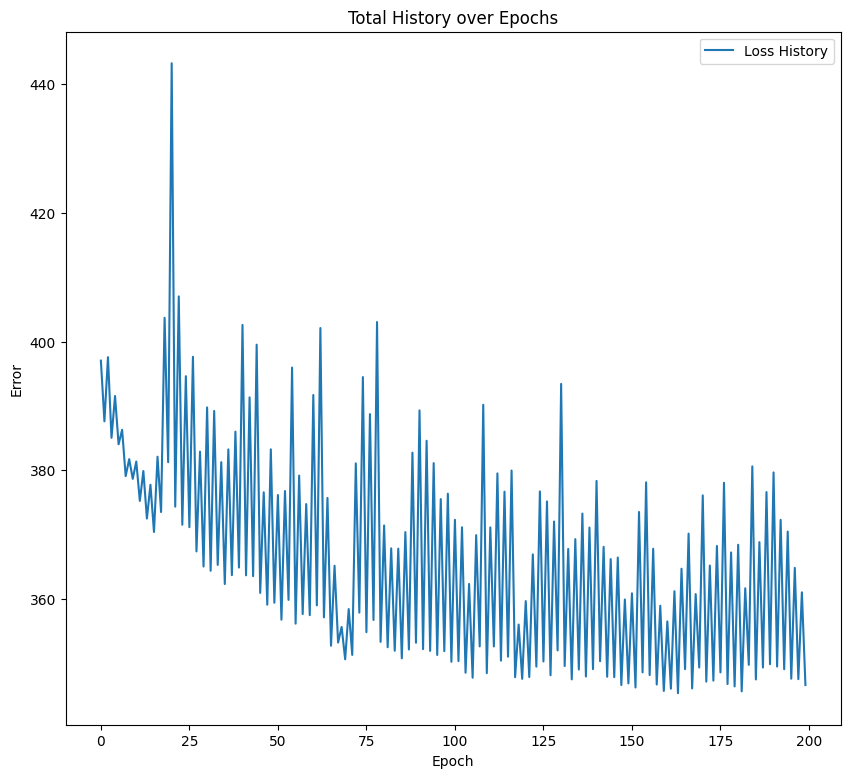

42
[array([[43.50054484]]), array([[45.54910181]]), array([[40.16336151]]), array([[42.98047599]]), array([[38.98186883]]), array([[39.61013955]]), array([[38.78096737]]), array([[40.10176911]]), array([[41.02734022]]), array([[41.48353448]]), array([[39.01067987]]), array([[38.66907752]]), array([[42.40578732]]), array([[43.1898293]]), array([[38.91756733]]), array([[38.73959954]]), array([[43.008306]]), array([[42.0272261]]), array([[44.1993454]]), array([[42.27616794]]), array([[44.95965683]]), array([[6.43945334]]), array([[8.03651977]]), array([[6.3059493]]), array([[8.4199424]]), array([[8.61175683]]), array([[8.6434187]]), array([[4.35213135]]), array([[7.67603383]]), array([[7.79214247]]), array([[9.07162872]]), array([[8.03549336]]), array([[7.10002839]]), array([[8.45012012]]), array([[7.64122393]]), array([[7.36112086]]), array([[7.51153295]]), array([[6.76757129]]), array([[7.15606892]]), array([[7.40557983]]), array([[8.93606021]]), array([[5.55201346]])]
Data to train: [[

Epoch 135/200 - Total Loss: 14919.9501, Recon Loss: 12754.3513, KL Loss: 21655.9888
Epoch 136/200 - Total Loss: 14590.9009, Recon Loss: 12757.5676, KL Loss: 18333.3330
Epoch 137/200 - Total Loss: 15190.2586, Recon Loss: 12894.6594, KL Loss: 22955.9914
Epoch 138/200 - Total Loss: 14650.9694, Recon Loss: 12888.4912, KL Loss: 17624.7827
Epoch 139/200 - Total Loss: 15593.7677, Recon Loss: 13082.4731, KL Loss: 25112.9453
Epoch 140/200 - Total Loss: 14545.9034, Recon Loss: 12781.2099, KL Loss: 17646.9353
Epoch 141/200 - Total Loss: 15217.9432, Recon Loss: 12875.0689, KL Loss: 23428.7430
Epoch 142/200 - Total Loss: 14620.1541, Recon Loss: 12768.2661, KL Loss: 18518.8801
Epoch 143/200 - Total Loss: 15564.1275, Recon Loss: 13090.4936, KL Loss: 24736.3385
Epoch 144/200 - Total Loss: 14567.3535, Recon Loss: 12806.4101, KL Loss: 17609.4336
Epoch 145/200 - Total Loss: 15284.3225, Recon Loss: 12912.5706, KL Loss: 23717.5190
Epoch 146/200 - Total Loss: 14588.9969, Recon Loss: 12803.4765, KL Loss: 178

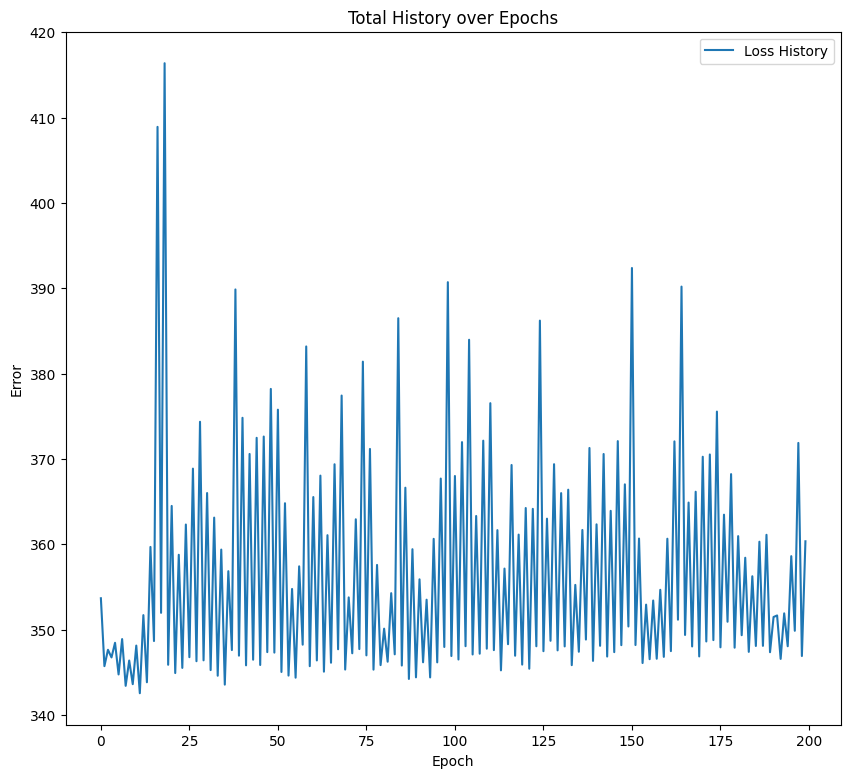

42
[array([[44.52407405]]), array([[45.23324381]]), array([[46.579353]]), array([[48.38401885]]), array([[46.69017971]]), array([[40.8530406]]), array([[45.36813859]]), array([[44.18494913]]), array([[42.04245465]]), array([[44.41146497]]), array([[42.3516553]]), array([[41.19273]]), array([[40.71628993]]), array([[39.84796786]]), array([[46.28645231]]), array([[40.88986954]]), array([[41.24986793]]), array([[41.73807614]]), array([[43.85335115]]), array([[47.28185318]]), array([[41.36236716]]), array([[5.85873735]]), array([[4.11496893]]), array([[2.69106716]]), array([[4.13781102]]), array([[2.33614677]]), array([[5.14488657]]), array([[6.52182299]]), array([[5.66853989]]), array([[4.43240661]]), array([[8.32335093]]), array([[2.11343619]]), array([[4.97921167]]), array([[4.52768857]]), array([[5.37460612]]), array([[3.67524861]]), array([[6.05560961]]), array([[4.66354123]]), array([[4.31831568]]), array([[5.9061574]]), array([[5.51189168]]), array([[5.31782264]])]
Data to train: [[

Epoch 140/200 - Total Loss: 15130.6004, Recon Loss: 12295.0554, KL Loss: 28355.4499
Epoch 141/200 - Total Loss: 15029.0881, Recon Loss: 12216.3758, KL Loss: 28127.1230
Epoch 142/200 - Total Loss: 15137.3051, Recon Loss: 12263.8437, KL Loss: 28734.6145
Epoch 143/200 - Total Loss: 15127.5487, Recon Loss: 12289.7493, KL Loss: 28377.9940
Epoch 144/200 - Total Loss: 15054.4518, Recon Loss: 12241.1035, KL Loss: 28133.4830
Epoch 145/200 - Total Loss: 15112.9603, Recon Loss: 12249.2615, KL Loss: 28636.9883
Epoch 146/200 - Total Loss: 15106.7420, Recon Loss: 12254.7390, KL Loss: 28520.0297
Epoch 147/200 - Total Loss: 14950.4688, Recon Loss: 12268.1292, KL Loss: 26823.3961
Epoch 148/200 - Total Loss: 15347.7858, Recon Loss: 12277.5383, KL Loss: 30702.4750
Epoch 149/200 - Total Loss: 15027.3789, Recon Loss: 12239.1895, KL Loss: 27881.8939
Epoch 150/200 - Total Loss: 15056.4107, Recon Loss: 12275.6330, KL Loss: 27807.7769
Epoch 151/200 - Total Loss: 15240.9758, Recon Loss: 12291.7372, KL Loss: 294

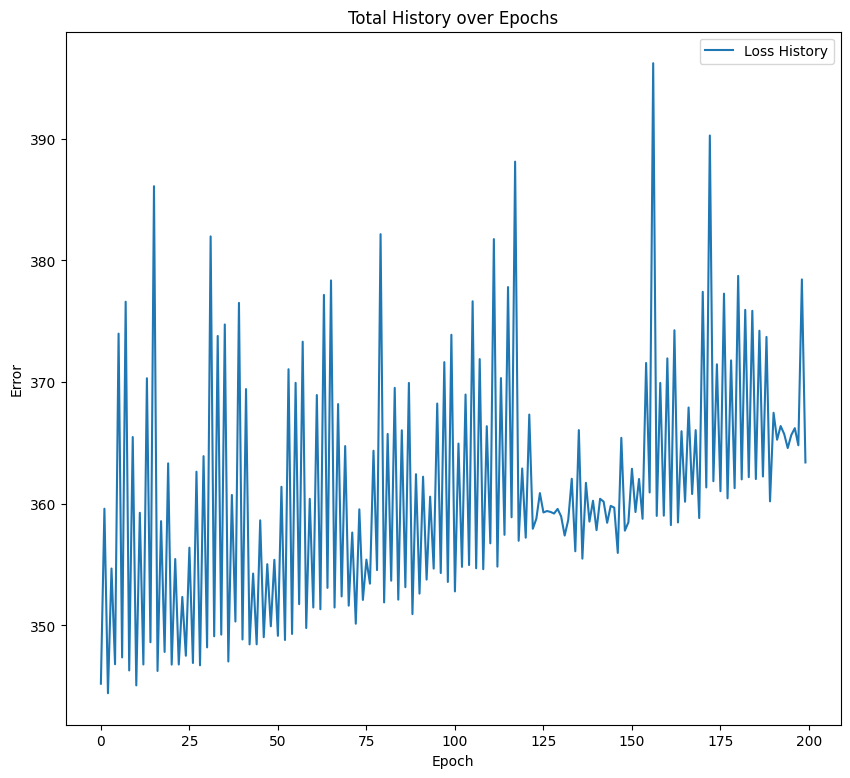

42
[array([[55.59094378]]), array([[53.35109571]]), array([[54.21880915]]), array([[55.02416523]]), array([[54.4619982]]), array([[53.50481654]]), array([[52.61559655]]), array([[52.34180946]]), array([[56.40116084]]), array([[54.32391156]]), array([[55.11099745]]), array([[55.39564068]]), array([[55.94499508]]), array([[58.335087]]), array([[53.67807162]]), array([[52.89595472]]), array([[56.78808754]]), array([[56.49077186]]), array([[54.39106447]]), array([[56.99726311]]), array([[54.06239648]]), array([[4.44589644]]), array([[7.26870451]]), array([[7.76540066]]), array([[3.85659687]]), array([[4.22571883]]), array([[4.83408824]]), array([[7.24531571]]), array([[4.4987703]]), array([[6.54599711]]), array([[6.04843931]]), array([[6.92705654]]), array([[6.3839058]]), array([[7.10978857]]), array([[5.24749247]]), array([[4.05708755]]), array([[3.89085399]]), array([[7.4117338]]), array([[4.44655463]]), array([[5.51503216]]), array([[4.61075526]]), array([[6.18242152]])]
Data to train: 

Epoch 147/200 - Total Loss: 15672.9333, Recon Loss: 12118.6231, KL Loss: 35543.1029
Epoch 148/200 - Total Loss: 16183.5026, Recon Loss: 12137.0711, KL Loss: 40464.3144
Epoch 149/200 - Total Loss: 15701.7508, Recon Loss: 12130.8241, KL Loss: 35709.2669
Epoch 150/200 - Total Loss: 16611.6866, Recon Loss: 12287.5767, KL Loss: 43241.0992
Epoch 151/200 - Total Loss: 15721.4285, Recon Loss: 12101.9024, KL Loss: 36195.2607
Epoch 152/200 - Total Loss: 16415.8352, Recon Loss: 12208.4245, KL Loss: 42074.1068
Epoch 153/200 - Total Loss: 15706.0527, Recon Loss: 12084.0185, KL Loss: 36220.3414
Epoch 154/200 - Total Loss: 15944.7548, Recon Loss: 12045.6107, KL Loss: 38991.4414
Epoch 155/200 - Total Loss: 15848.1729, Recon Loss: 12072.3910, KL Loss: 37757.8190
Epoch 156/200 - Total Loss: 15822.7454, Recon Loss: 12046.5452, KL Loss: 37762.0018
Epoch 157/200 - Total Loss: 15817.9799, Recon Loss: 12139.1638, KL Loss: 36788.1617
Epoch 158/200 - Total Loss: 16291.1121, Recon Loss: 12144.0310, KL Loss: 414

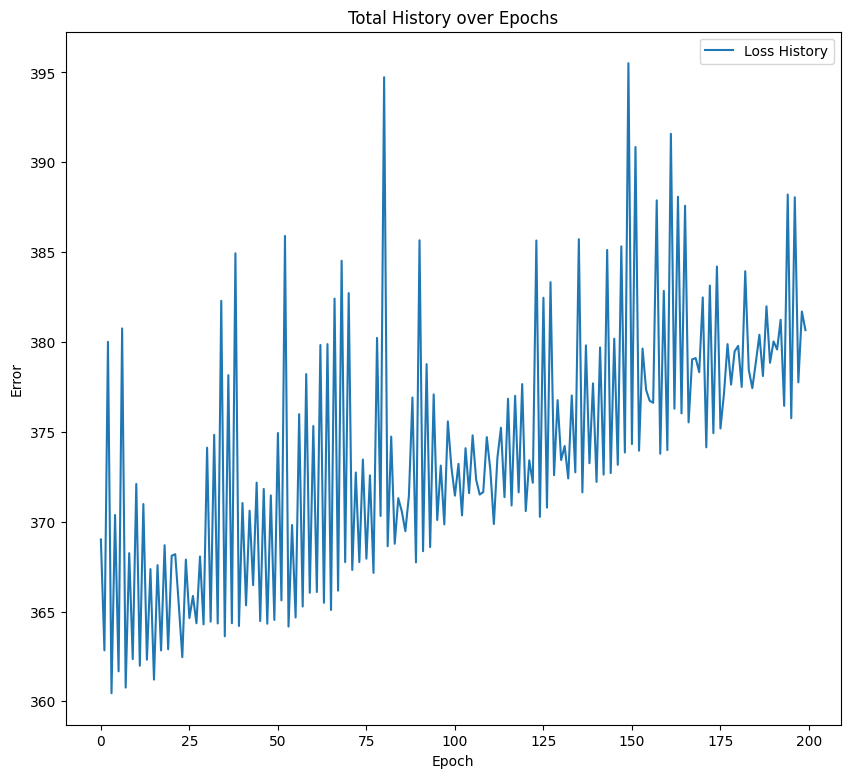

42
[array([[57.49688204]]), array([[60.33036092]]), array([[51.21758102]]), array([[54.81213471]]), array([[59.34535454]]), array([[62.70951223]]), array([[62.45922839]]), array([[60.45434383]]), array([[57.64173095]]), array([[61.17828221]]), array([[64.91550835]]), array([[57.4502768]]), array([[58.99990693]]), array([[61.29619026]]), array([[59.00383551]]), array([[56.19905477]]), array([[61.21865276]]), array([[63.66033279]]), array([[65.80048535]]), array([[63.06396602]]), array([[60.86666182]]), array([[4.10719214]]), array([[4.35649142]]), array([[2.15435012]]), array([[6.05841654]]), array([[5.43253582]]), array([[4.42551821]]), array([[1.70451966]]), array([[3.38242424]]), array([[6.0408143]]), array([[4.03732484]]), array([[2.75156226]]), array([[3.8492941]]), array([[5.26283388]]), array([[4.8060836]]), array([[6.84146171]]), array([[2.87291895]]), array([[5.97729044]]), array([[4.09462596]]), array([[5.31444724]]), array([[5.61593569]]), array([[3.46860337]])]
Data to train

Epoch 147/200 - Total Loss: 14488.7871, Recon Loss: 12728.0335, KL Loss: 17607.5362
Epoch 148/200 - Total Loss: 15875.8078, Recon Loss: 13151.7106, KL Loss: 27240.9719
Epoch 149/200 - Total Loss: 14447.8166, Recon Loss: 12606.3358, KL Loss: 18414.8079
Epoch 150/200 - Total Loss: 15331.5917, Recon Loss: 12850.4583, KL Loss: 24811.3348
Epoch 151/200 - Total Loss: 14485.2075, Recon Loss: 12685.7705, KL Loss: 17994.3703
Epoch 152/200 - Total Loss: 15608.2588, Recon Loss: 12955.6831, KL Loss: 26525.7577
Epoch 153/200 - Total Loss: 14483.8666, Recon Loss: 12625.6600, KL Loss: 18582.0662
Epoch 154/200 - Total Loss: 15341.4472, Recon Loss: 12817.6081, KL Loss: 25238.3910
Epoch 155/200 - Total Loss: 14469.5648, Recon Loss: 12642.0484, KL Loss: 18275.1642
Epoch 156/200 - Total Loss: 15025.6516, Recon Loss: 12657.1640, KL Loss: 23684.8760
Epoch 157/200 - Total Loss: 14387.6614, Recon Loss: 12538.4252, KL Loss: 18492.3618
Epoch 158/200 - Total Loss: 15038.9810, Recon Loss: 12681.4889, KL Loss: 235

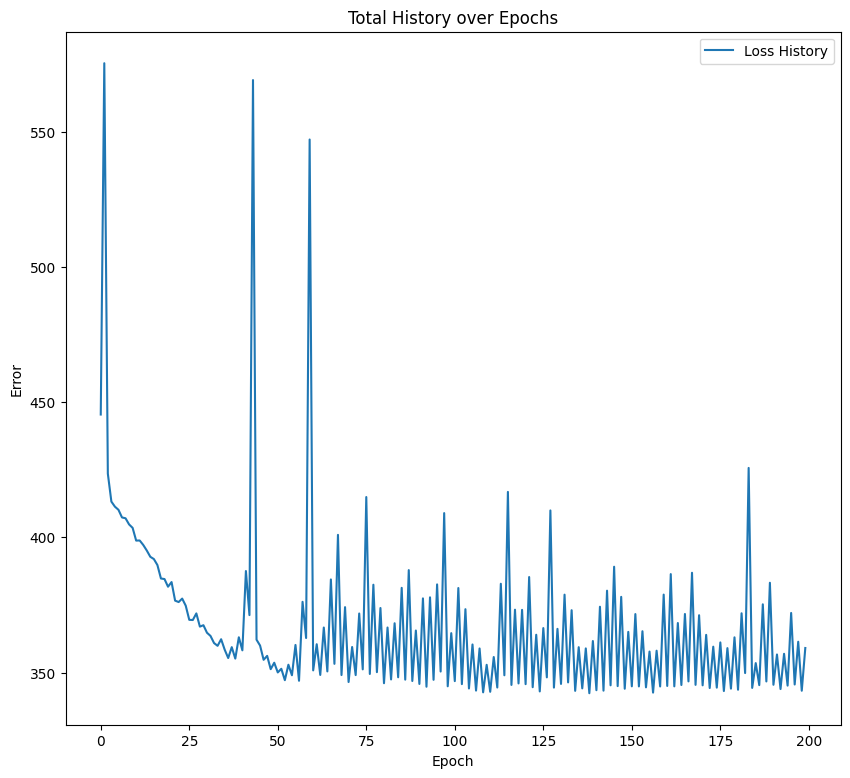

42
[array([[69.84812447]]), array([[67.18344645]]), array([[33.19071139]]), array([[35.97196041]]), array([[44.45384926]]), array([[35.35301226]]), array([[31.24661903]]), array([[31.30857645]]), array([[31.3144645]]), array([[28.58790293]]), array([[34.42087257]]), array([[36.15450925]]), array([[29.58819966]]), array([[43.24600378]]), array([[42.715059]]), array([[45.15575384]]), array([[42.28787404]]), array([[40.84642801]]), array([[53.69847517]]), array([[47.23269872]]), array([[52.54590966]]), array([[2.22041238]]), array([[3.58797738]]), array([[2.65583709]]), array([[2.36659072]]), array([[2.66219446]]), array([[4.4822454]]), array([[4.33420116]]), array([[3.12319258]]), array([[3.19703864]]), array([[4.61099661]]), array([[4.15239008]]), array([[4.50183763]]), array([[2.88604384]]), array([[2.80283208]]), array([[1.54118086]]), array([[1.70517851]]), array([[4.58364652]]), array([[3.72208377]]), array([[3.79129679]]), array([[4.70983552]]), array([[4.57795922]])]
Data to train

Epoch 144/200 - Total Loss: 15456.0957, Recon Loss: 13051.4229, KL Loss: 24046.7282
Epoch 145/200 - Total Loss: 14211.7884, Recon Loss: 12656.9293, KL Loss: 15548.5907
Epoch 146/200 - Total Loss: 15859.7832, Recon Loss: 13304.2548, KL Loss: 25555.2839
Epoch 147/200 - Total Loss: 14121.6142, Recon Loss: 12538.4541, KL Loss: 15831.6005
Epoch 148/200 - Total Loss: 15037.5921, Recon Loss: 12768.0851, KL Loss: 22695.0700
Epoch 149/200 - Total Loss: 14198.5798, Recon Loss: 12583.2569, KL Loss: 16153.2286
Epoch 150/200 - Total Loss: 15562.9319, Recon Loss: 13116.3844, KL Loss: 24465.4747
Epoch 151/200 - Total Loss: 14266.5150, Recon Loss: 12681.0282, KL Loss: 15854.8681
Epoch 152/200 - Total Loss: 15536.3492, Recon Loss: 13078.4390, KL Loss: 24579.1019
Epoch 153/200 - Total Loss: 14416.4160, Recon Loss: 12821.8826, KL Loss: 15945.3339
Epoch 154/200 - Total Loss: 16289.7830, Recon Loss: 13531.8386, KL Loss: 27579.4441
Epoch 155/200 - Total Loss: 14224.6881, Recon Loss: 12547.2725, KL Loss: 167

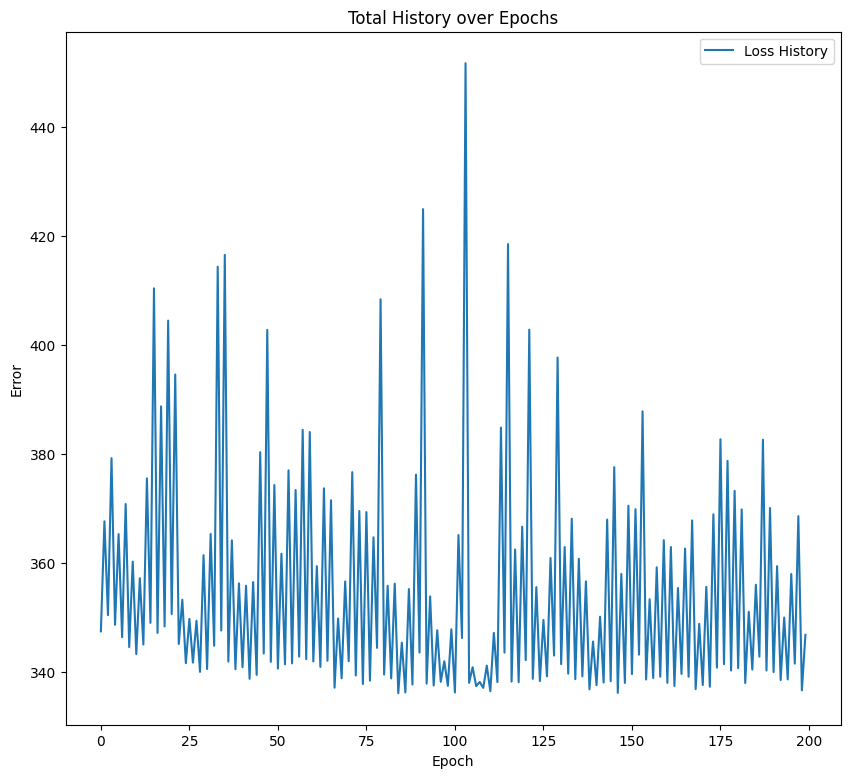

42
[array([[36.31994772]]), array([[35.8083066]]), array([[41.03120218]]), array([[40.93255958]]), array([[42.37993296]]), array([[38.24973339]]), array([[40.24338285]]), array([[39.00784611]]), array([[38.45008455]]), array([[32.01084603]]), array([[48.62038526]]), array([[53.10254706]]), array([[49.9652324]]), array([[26.27899875]]), array([[39.15741015]]), array([[36.05894062]]), array([[40.52612364]]), array([[43.06094578]]), array([[33.59498204]]), array([[31.96052247]]), array([[69.19002034]]), array([[2.47736004]]), array([[4.05872093]]), array([[3.65349459]]), array([[2.67336378]]), array([[5.91285455]]), array([[2.6713189]]), array([[6.83066741]]), array([[3.86637436]]), array([[4.84984028]]), array([[2.11869814]]), array([[6.08582824]]), array([[6.31651843]]), array([[4.49887058]]), array([[3.47739064]]), array([[3.77804343]]), array([[4.1445769]]), array([[7.51112138]]), array([[0.81180583]]), array([[3.08573323]]), array([[2.06005569]]), array([[3.27753011]])]
Data to train

Epoch 146/200 - Total Loss: 14473.2974, Recon Loss: 12246.1250, KL Loss: 22271.7245
Epoch 147/200 - Total Loss: 15840.3795, Recon Loss: 12633.1065, KL Loss: 32072.7305
Epoch 148/200 - Total Loss: 14465.8360, Recon Loss: 12197.6188, KL Loss: 22682.1727
Epoch 149/200 - Total Loss: 15903.9040, Recon Loss: 12676.5522, KL Loss: 32273.5187
Epoch 150/200 - Total Loss: 14511.2295, Recon Loss: 12239.3731, KL Loss: 22718.5647
Epoch 151/200 - Total Loss: 15877.9153, Recon Loss: 12611.3585, KL Loss: 32665.5680
Epoch 152/200 - Total Loss: 14557.8323, Recon Loss: 12192.0003, KL Loss: 23658.3201
Epoch 153/200 - Total Loss: 15506.8885, Recon Loss: 12417.5042, KL Loss: 30893.8432
Epoch 154/200 - Total Loss: 14526.5977, Recon Loss: 12176.3355, KL Loss: 23502.6222
Epoch 155/200 - Total Loss: 15499.4316, Recon Loss: 12364.1077, KL Loss: 31353.2387
Epoch 156/200 - Total Loss: 14537.8118, Recon Loss: 12136.5803, KL Loss: 24012.3141
Epoch 157/200 - Total Loss: 15205.5436, Recon Loss: 12258.6441, KL Loss: 294

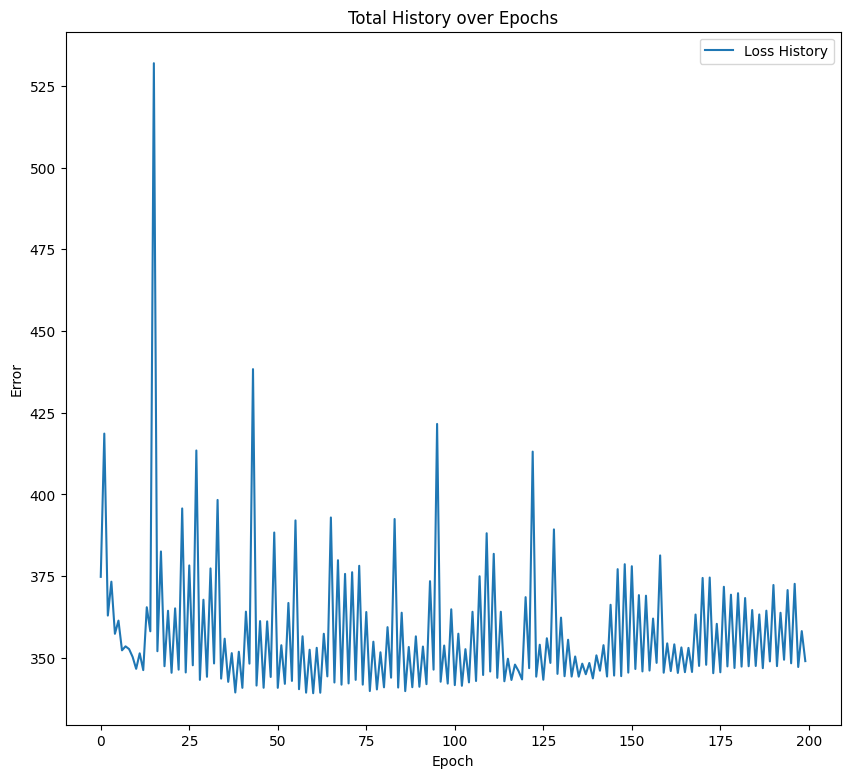

42
[array([[68.69597473]]), array([[49.47119171]]), array([[49.27585988]]), array([[48.39114459]]), array([[50.2671424]]), array([[47.79828848]]), array([[49.24001703]]), array([[47.39402963]]), array([[47.09509369]]), array([[46.56565027]]), array([[48.77534519]]), array([[49.17244517]]), array([[48.96270048]]), array([[49.09969397]]), array([[58.77321042]]), array([[60.47187628]]), array([[59.69859828]]), array([[67.83415996]]), array([[70.21400473]]), array([[41.08916937]]), array([[44.93805025]]), array([[7.17622788]]), array([[6.50793391]]), array([[6.07913338]]), array([[6.24294884]]), array([[4.41548413]]), array([[7.005378]]), array([[7.0697191]]), array([[7.88318601]]), array([[6.92488427]]), array([[5.705345]]), array([[5.37388933]]), array([[6.67739616]]), array([[7.30251777]]), array([[5.61877559]]), array([[7.12505749]]), array([[7.43079856]]), array([[8.03998795]]), array([[5.80872581]]), array([[5.38257469]]), array([[6.89667627]]), array([[6.07608931]])]
Data to train: 

Epoch 137/200 - Total Loss: 16220.9624, Recon Loss: 13550.0803, KL Loss: 26708.8215
Epoch 138/200 - Total Loss: 15887.9918, Recon Loss: 13474.4977, KL Loss: 24134.9414
Epoch 139/200 - Total Loss: 15962.9059, Recon Loss: 13429.8415, KL Loss: 25330.6441
Epoch 140/200 - Total Loss: 15855.7541, Recon Loss: 13437.6378, KL Loss: 24181.1628
Epoch 141/200 - Total Loss: 16309.1260, Recon Loss: 13557.6831, KL Loss: 27514.4291
Epoch 142/200 - Total Loss: 15975.1308, Recon Loss: 13369.7946, KL Loss: 26053.3618
Epoch 143/200 - Total Loss: 15983.6749, Recon Loss: 13500.8614, KL Loss: 24828.1346
Epoch 144/200 - Total Loss: 15945.0624, Recon Loss: 13339.9814, KL Loss: 26050.8105
Epoch 145/200 - Total Loss: 15889.0137, Recon Loss: 13486.9322, KL Loss: 24020.8145
Epoch 146/200 - Total Loss: 16468.7625, Recon Loss: 13487.3708, KL Loss: 29813.9173
Epoch 147/200 - Total Loss: 15647.2178, Recon Loss: 13189.4328, KL Loss: 24577.8497
Epoch 148/200 - Total Loss: 15845.0357, Recon Loss: 13257.9896, KL Loss: 258

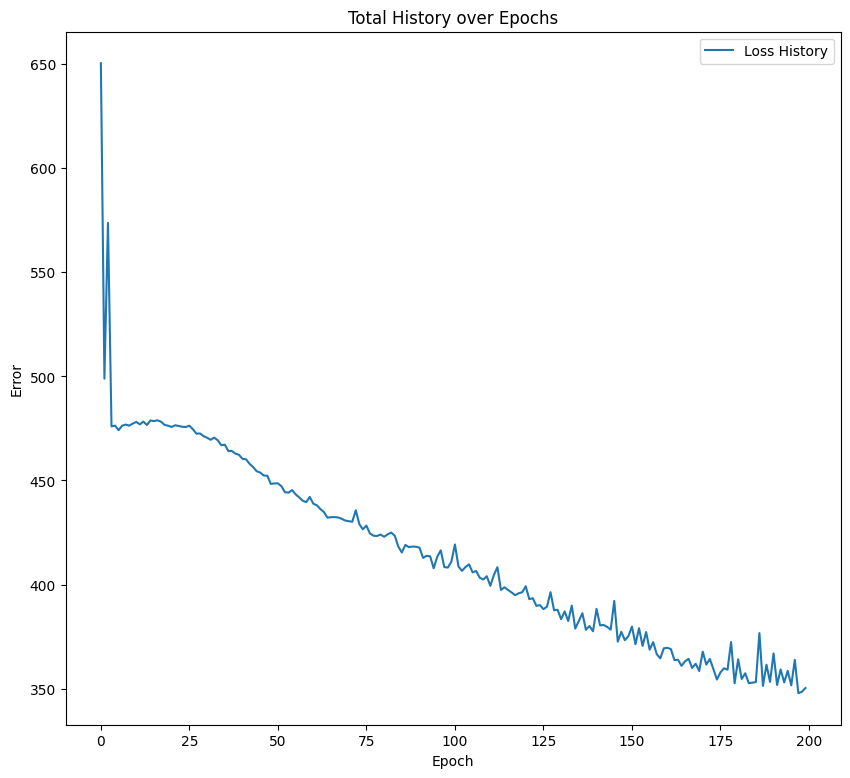

42
[array([[38.7242748]]), array([[36.26073233]]), array([[44.02674592]]), array([[42.70491201]]), array([[44.61234375]]), array([[45.92353716]]), array([[44.34356654]]), array([[42.14788926]]), array([[45.07780068]]), array([[46.96285528]]), array([[51.14317985]]), array([[51.07838286]]), array([[46.71542234]]), array([[49.31249568]]), array([[52.6933632]]), array([[51.42365436]]), array([[51.48413393]]), array([[41.26416181]]), array([[43.6395332]]), array([[44.53518431]]), array([[23.08617098]]), array([[4.59552881]]), array([[3.97437948]]), array([[1.99407972]]), array([[4.81776788]]), array([[5.66415482]]), array([[8.862907]]), array([[7.15661671]]), array([[6.72071318]]), array([[4.98213343]]), array([[2.16749693]]), array([[9.22404259]]), array([[8.43520176]]), array([[7.73413739]]), array([[7.79714699]]), array([[5.78570041]]), array([[2.77915756]]), array([[10.15471901]]), array([[7.7215089]]), array([[5.78682736]]), array([[7.41117689]]), array([[6.19985593]])]
Data to train:

Epoch 134/200 - Total Loss: 14706.2227, Recon Loss: 12962.9058, KL Loss: 17433.1683
Epoch 135/200 - Total Loss: 13931.9481, Recon Loss: 12772.5566, KL Loss: 11593.9145
Epoch 136/200 - Total Loss: 14744.6119, Recon Loss: 12960.4965, KL Loss: 17841.1545
Epoch 137/200 - Total Loss: 13979.9929, Recon Loss: 12833.9453, KL Loss: 11460.4758
Epoch 138/200 - Total Loss: 15439.9095, Recon Loss: 13435.2528, KL Loss: 20046.5666
Epoch 139/200 - Total Loss: 14033.7449, Recon Loss: 12918.0818, KL Loss: 11156.6311
Epoch 140/200 - Total Loss: 15674.0833, Recon Loss: 13585.8743, KL Loss: 20882.0899
Epoch 141/200 - Total Loss: 13992.8801, Recon Loss: 12863.4972, KL Loss: 11293.8282
Epoch 142/200 - Total Loss: 15207.8033, Recon Loss: 13237.2748, KL Loss: 19705.2851
Epoch 143/200 - Total Loss: 14166.3969, Recon Loss: 13012.6773, KL Loss: 11537.1962
Epoch 144/200 - Total Loss: 16536.5246, Recon Loss: 14184.3775, KL Loss: 23521.4705
Epoch 145/200 - Total Loss: 13971.4502, Recon Loss: 12801.9424, KL Loss: 116

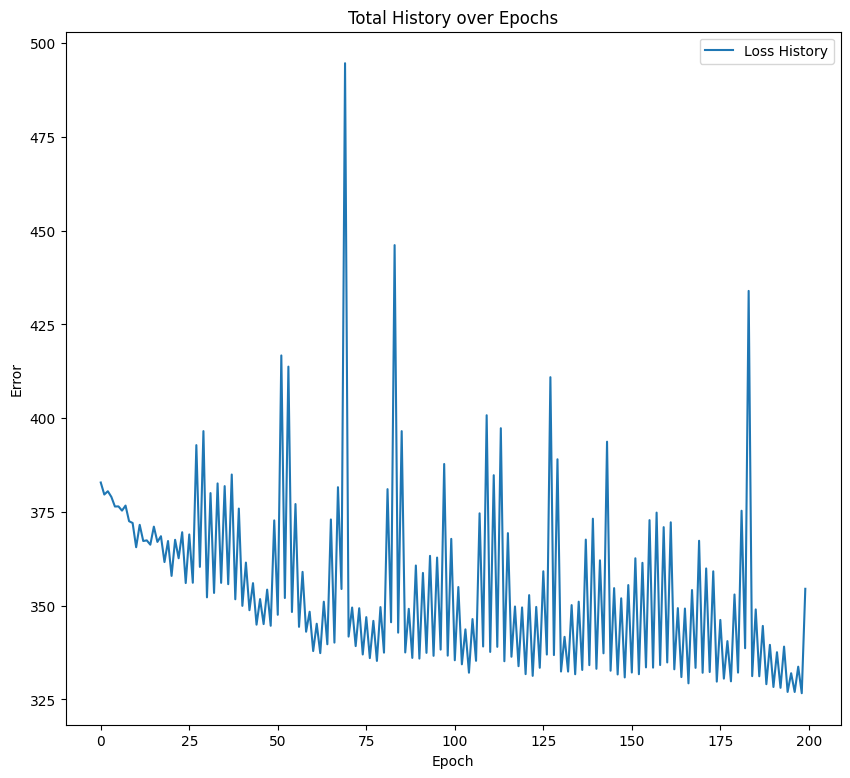

42
[array([[36.17732226]]), array([[34.87753748]]), array([[38.35552063]]), array([[32.77814975]]), array([[37.18591343]]), array([[42.25656788]]), array([[35.81958555]]), array([[39.73925758]]), array([[33.48884025]]), array([[39.07324416]]), array([[37.51486934]]), array([[41.39172969]]), array([[25.06864053]]), array([[21.09984871]]), array([[22.46479209]]), array([[29.96536327]]), array([[30.13338529]]), array([[19.41880666]]), array([[38.49897066]]), array([[30.6633636]]), array([[30.61971429]]), array([[2.82318965]]), array([[3.85278343]]), array([[3.29878901]]), array([[4.05218711]]), array([[2.2016968]]), array([[2.11796082]]), array([[1.87578169]]), array([[2.71444745]]), array([[1.98876907]]), array([[2.43382721]]), array([[2.27595596]]), array([[1.53217368]]), array([[5.17760286]]), array([[2.58267132]]), array([[3.99179746]]), array([[1.0680354]]), array([[2.22052874]]), array([[1.14763517]]), array([[2.54278444]]), array([[2.4467325]]), array([[3.84089096]])]
Data to train

Epoch 148/200 - Total Loss: 14735.6453, Recon Loss: 12325.9696, KL Loss: 24096.7568
Epoch 149/200 - Total Loss: 14167.7172, Recon Loss: 12244.2210, KL Loss: 19234.9628
Epoch 150/200 - Total Loss: 14580.3584, Recon Loss: 12201.1275, KL Loss: 23792.3093
Epoch 151/200 - Total Loss: 14167.2163, Recon Loss: 12152.4148, KL Loss: 20148.0157
Epoch 152/200 - Total Loss: 14420.4877, Recon Loss: 12244.6189, KL Loss: 21758.6874
Epoch 153/200 - Total Loss: 14257.3956, Recon Loss: 12252.2424, KL Loss: 20051.5318
Epoch 154/200 - Total Loss: 15060.7745, Recon Loss: 12493.7829, KL Loss: 25669.9164
Epoch 155/200 - Total Loss: 14097.9094, Recon Loss: 12180.8048, KL Loss: 19171.0459
Epoch 156/200 - Total Loss: 14743.7001, Recon Loss: 12319.9999, KL Loss: 24237.0029
Epoch 157/200 - Total Loss: 14170.0514, Recon Loss: 12206.3663, KL Loss: 19636.8507
Epoch 158/200 - Total Loss: 14783.4752, Recon Loss: 12352.4676, KL Loss: 24310.0760
Epoch 159/200 - Total Loss: 14145.2624, Recon Loss: 12245.3314, KL Loss: 189

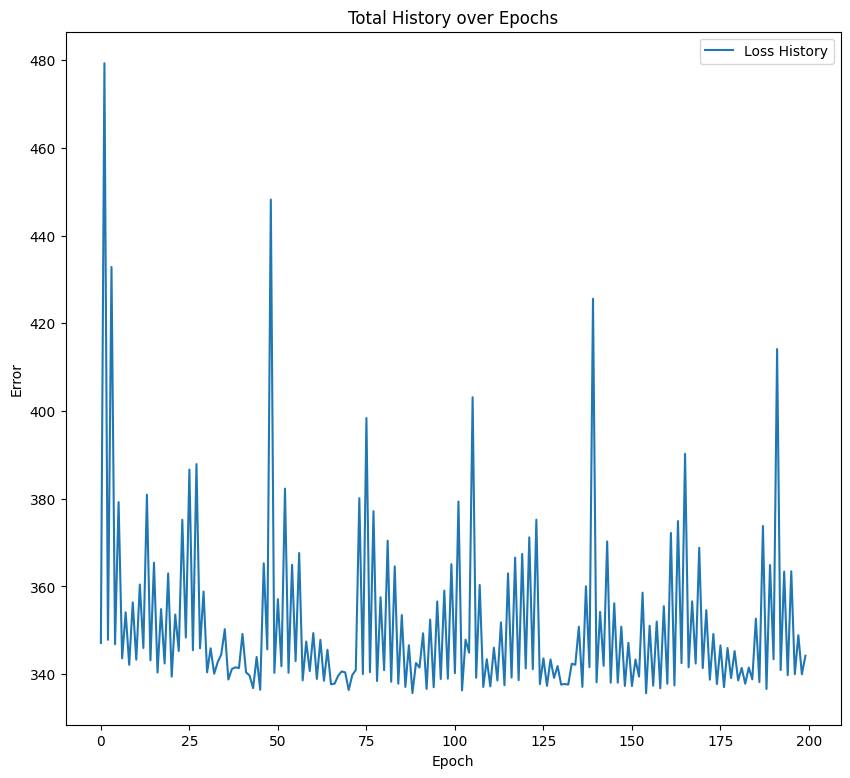

42
[array([[46.35225137]]), array([[42.53279585]]), array([[45.46376362]]), array([[46.17933257]]), array([[47.87407414]]), array([[41.59260081]]), array([[41.00709721]]), array([[43.98716587]]), array([[31.00535]]), array([[45.87008949]]), array([[48.29033825]]), array([[42.3509605]]), array([[43.66389687]]), array([[45.91849873]]), array([[31.55781942]]), array([[55.90135144]]), array([[58.22870379]]), array([[56.7100577]]), array([[39.53098633]]), array([[51.6990398]]), array([[28.47590233]]), array([[6.29286286]]), array([[6.88012368]]), array([[6.1107052]]), array([[3.77983777]]), array([[6.99292387]]), array([[4.75254571]]), array([[7.84712177]]), array([[5.32273231]]), array([[3.77364907]]), array([[2.52054618]]), array([[7.29892281]]), array([[4.73633029]]), array([[-0.70571879]]), array([[3.77646394]]), array([[6.53953534]]), array([[5.36942433]]), array([[2.43571049]]), array([[4.10472155]]), array([[3.8920515]]), array([[4.61365791]]), array([[4.43593341]])]
Data to train: [

Epoch 154/200 - Total Loss: 14496.3478, Recon Loss: 12021.1691, KL Loss: 24751.7869
Epoch 155/200 - Total Loss: 14556.8967, Recon Loss: 12086.2374, KL Loss: 24706.5927
Epoch 156/200 - Total Loss: 14571.8986, Recon Loss: 12040.3558, KL Loss: 25315.4285
Epoch 157/200 - Total Loss: 14415.9941, Recon Loss: 12054.6128, KL Loss: 23613.8136
Epoch 158/200 - Total Loss: 14554.1142, Recon Loss: 12045.5552, KL Loss: 25085.5902
Epoch 159/200 - Total Loss: 14467.6174, Recon Loss: 12187.5562, KL Loss: 22800.6111
Epoch 160/200 - Total Loss: 15565.5929, Recon Loss: 12512.0198, KL Loss: 30535.7307
Epoch 161/200 - Total Loss: 14426.6503, Recon Loss: 12216.4527, KL Loss: 22101.9762
Epoch 162/200 - Total Loss: 15415.9709, Recon Loss: 12382.9240, KL Loss: 30330.4687
Epoch 163/200 - Total Loss: 14496.0614, Recon Loss: 12224.5929, KL Loss: 22714.6855
Epoch 164/200 - Total Loss: 16009.0062, Recon Loss: 12729.8143, KL Loss: 32791.9191
Epoch 165/200 - Total Loss: 14396.5908, Recon Loss: 12122.4072, KL Loss: 227

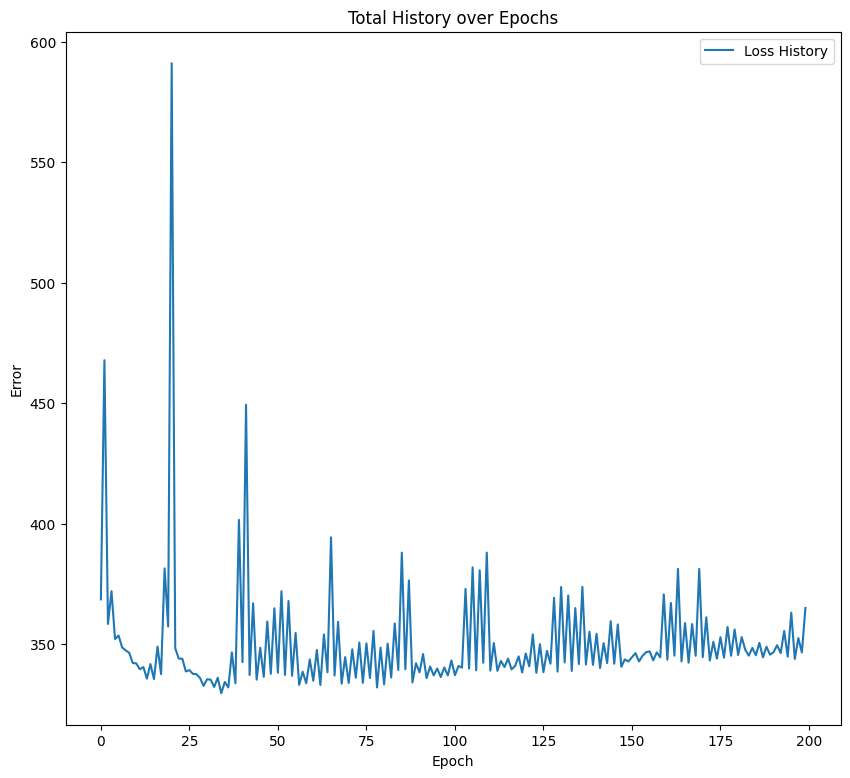

42
[array([[24.98087092]]), array([[48.17511463]]), array([[50.49831758]]), array([[48.02795552]]), array([[47.97785248]]), array([[51.90379948]]), array([[50.18757804]]), array([[49.34483589]]), array([[44.65865448]]), array([[56.09823552]]), array([[56.83239918]]), array([[48.15837322]]), array([[44.72348292]]), array([[45.19044799]]), array([[46.41669129]]), array([[47.22704659]]), array([[47.89050899]]), array([[43.82182321]]), array([[49.15447229]]), array([[52.47391831]]), array([[54.8918223]]), array([[2.89800923]]), array([[5.20363538]]), array([[4.18360592]]), array([[4.23112566]]), array([[5.65378898]]), array([[4.93075479]]), array([[4.20164084]]), array([[4.5230837]]), array([[2.91942752]]), array([[5.8657534]]), array([[7.34884446]]), array([[2.46437268]]), array([[3.55833099]]), array([[2.02758652]]), array([[5.09103821]]), array([[4.72774168]]), array([[3.13615102]]), array([[5.39744123]]), array([[4.99547077]]), array([[5.01913983]]), array([[2.24800475]])]
Data to trai

Epoch 150/200 - Total Loss: 15088.2140, Recon Loss: 12117.1849, KL Loss: 29710.2919
Epoch 151/200 - Total Loss: 14756.3810, Recon Loss: 12160.1849, KL Loss: 25961.9608
Epoch 152/200 - Total Loss: 15875.7590, Recon Loss: 12475.5133, KL Loss: 34002.4572
Epoch 153/200 - Total Loss: 14638.3272, Recon Loss: 12086.0204, KL Loss: 25523.0677
Epoch 154/200 - Total Loss: 15166.4446, Recon Loss: 12124.6570, KL Loss: 30417.8763
Epoch 155/200 - Total Loss: 14625.3925, Recon Loss: 11973.8291, KL Loss: 26515.6341
Epoch 156/200 - Total Loss: 14826.8913, Recon Loss: 12007.7343, KL Loss: 28191.5702
Epoch 157/200 - Total Loss: 14721.7199, Recon Loss: 12034.2700, KL Loss: 26874.4989
Epoch 158/200 - Total Loss: 14978.9453, Recon Loss: 12033.0677, KL Loss: 29458.7761
Epoch 159/200 - Total Loss: 14636.2198, Recon Loss: 11946.9903, KL Loss: 26892.2949
Epoch 160/200 - Total Loss: 14795.9936, Recon Loss: 11958.4166, KL Loss: 28375.7696
Epoch 161/200 - Total Loss: 14930.3620, Recon Loss: 12059.8630, KL Loss: 287

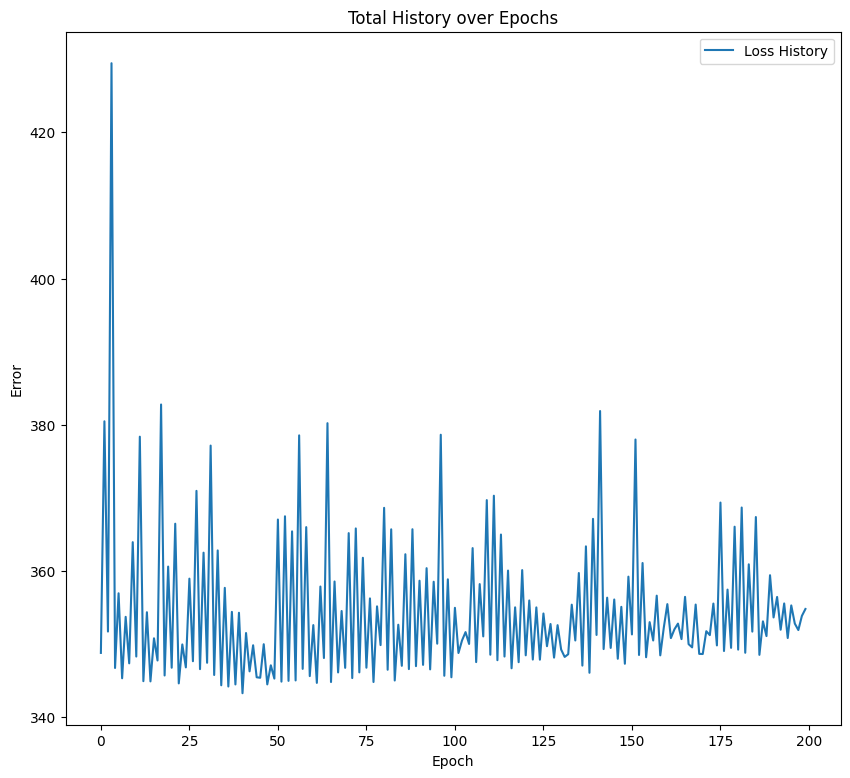

42
[array([[60.21226238]]), array([[50.13979557]]), array([[45.20068879]]), array([[55.74330805]]), array([[60.32881077]]), array([[38.73656826]]), array([[54.60369164]]), array([[59.15616346]]), array([[46.89847073]]), array([[54.86391689]]), array([[44.69684395]]), array([[52.52037462]]), array([[68.47527835]]), array([[63.57122151]]), array([[57.0459411]]), array([[64.79717384]]), array([[63.12880349]]), array([[61.20895698]]), array([[59.62608346]]), array([[65.21720045]]), array([[61.87582154]]), array([[8.76438053]]), array([[12.68179371]]), array([[6.49011054]]), array([[9.90703302]]), array([[7.3455507]]), array([[14.22557712]]), array([[5.30940963]]), array([[6.78890995]]), array([[8.61360726]]), array([[10.11134577]]), array([[10.8981311]]), array([[13.72004758]]), array([[10.33734899]]), array([[6.95863346]]), array([[8.8602549]]), array([[6.84532587]]), array([[9.21921152]]), array([[6.43169674]]), array([[7.24080654]]), array([[11.11356052]]), array([[7.59084195]])]
Data t

Epoch 138/200 - Total Loss: 15054.8209, Recon Loss: 12612.9393, KL Loss: 24418.8162
Epoch 139/200 - Total Loss: 14024.2430, Recon Loss: 12288.6349, KL Loss: 17356.0813
Epoch 140/200 - Total Loss: 14636.3200, Recon Loss: 12353.7367, KL Loss: 22825.8333
Epoch 141/200 - Total Loss: 14023.3668, Recon Loss: 12257.8951, KL Loss: 17654.7170
Epoch 142/200 - Total Loss: 14733.9776, Recon Loss: 12435.2615, KL Loss: 22987.1607
Epoch 143/200 - Total Loss: 14106.7867, Recon Loss: 12358.8431, KL Loss: 17479.4364
Epoch 144/200 - Total Loss: 15058.9593, Recon Loss: 12586.8890, KL Loss: 24720.7032
Epoch 145/200 - Total Loss: 14024.8525, Recon Loss: 12263.7321, KL Loss: 17611.2046
Epoch 146/200 - Total Loss: 14986.9662, Recon Loss: 12506.5703, KL Loss: 24803.9587
Epoch 147/200 - Total Loss: 14064.1887, Recon Loss: 12276.3291, KL Loss: 17878.5960
Epoch 148/200 - Total Loss: 14457.7157, Recon Loss: 12244.4139, KL Loss: 22133.0176
Epoch 149/200 - Total Loss: 14135.6912, Recon Loss: 12342.2495, KL Loss: 179

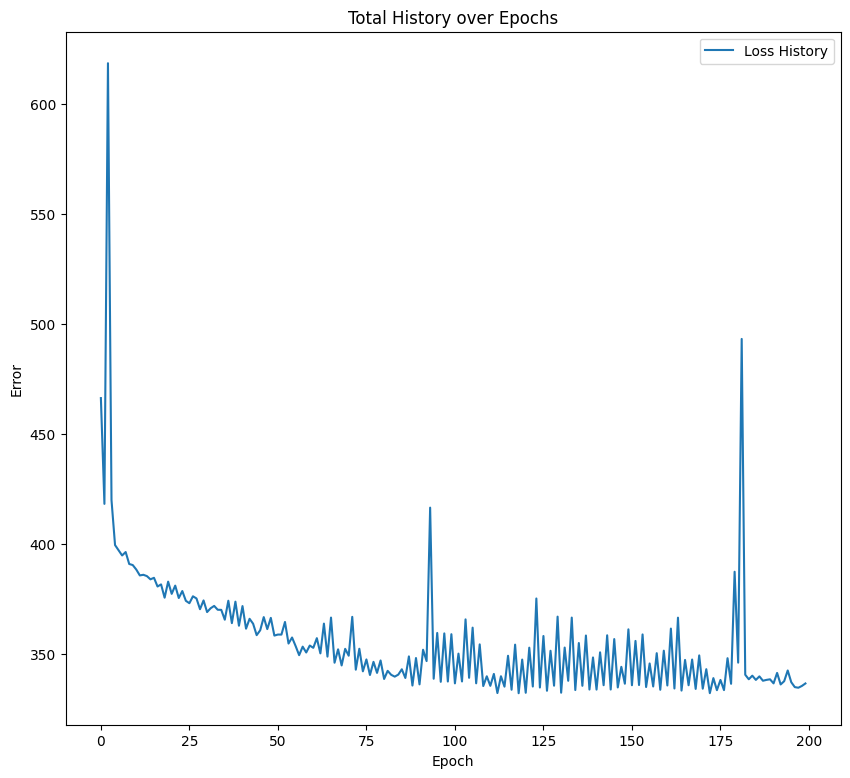

42
[array([[46.61281698]]), array([[52.72260061]]), array([[41.56128648]]), array([[36.63765548]]), array([[39.50717286]]), array([[36.45424364]]), array([[40.62262672]]), array([[38.83512107]]), array([[40.89452564]]), array([[40.79269405]]), array([[34.47649774]]), array([[37.57832522]]), array([[56.73016557]]), array([[55.525645]]), array([[51.30993185]]), array([[44.76925032]]), array([[28.8096462]]), array([[37.4175958]]), array([[56.53503589]]), array([[36.843778]]), array([[49.15245387]]), array([[2.91182548]]), array([[5.48356437]]), array([[2.69791922]]), array([[6.02357104]]), array([[2.97150349]]), array([[4.08203823]]), array([[7.23671407]]), array([[5.20327084]]), array([[3.79199239]]), array([[5.55747468]]), array([[2.43854936]]), array([[4.84850657]]), array([[6.71665333]]), array([[7.72059664]]), array([[9.33668691]]), array([[7.7121897]]), array([[3.32276975]]), array([[5.55190927]]), array([[4.20011676]]), array([[8.56884928]]), array([[4.19280298]])]
Data to train: [

Epoch 150/200 - Total Loss: 14260.4821, Recon Loss: 12142.8719, KL Loss: 21176.1023
Epoch 151/200 - Total Loss: 14560.8258, Recon Loss: 12070.1476, KL Loss: 24906.7816
Epoch 152/200 - Total Loss: 14290.9415, Recon Loss: 12063.5498, KL Loss: 22273.9169
Epoch 153/200 - Total Loss: 14631.9408, Recon Loss: 12162.1626, KL Loss: 24697.7820
Epoch 154/200 - Total Loss: 14205.9797, Recon Loss: 12045.7246, KL Loss: 21602.5517
Epoch 155/200 - Total Loss: 14456.0330, Recon Loss: 12165.9234, KL Loss: 22901.0952
Epoch 156/200 - Total Loss: 14738.9267, Recon Loss: 12161.0477, KL Loss: 25778.7904
Epoch 157/200 - Total Loss: 14314.5000, Recon Loss: 12123.0157, KL Loss: 21914.8430
Epoch 158/200 - Total Loss: 14770.7006, Recon Loss: 12220.2884, KL Loss: 25504.1219
Epoch 159/200 - Total Loss: 14566.0930, Recon Loss: 12483.0862, KL Loss: 20830.0682
Epoch 160/200 - Total Loss: 17327.5586, Recon Loss: 13801.7720, KL Loss: 35257.8662
Epoch 161/200 - Total Loss: 14334.2356, Recon Loss: 12274.6281, KL Loss: 205

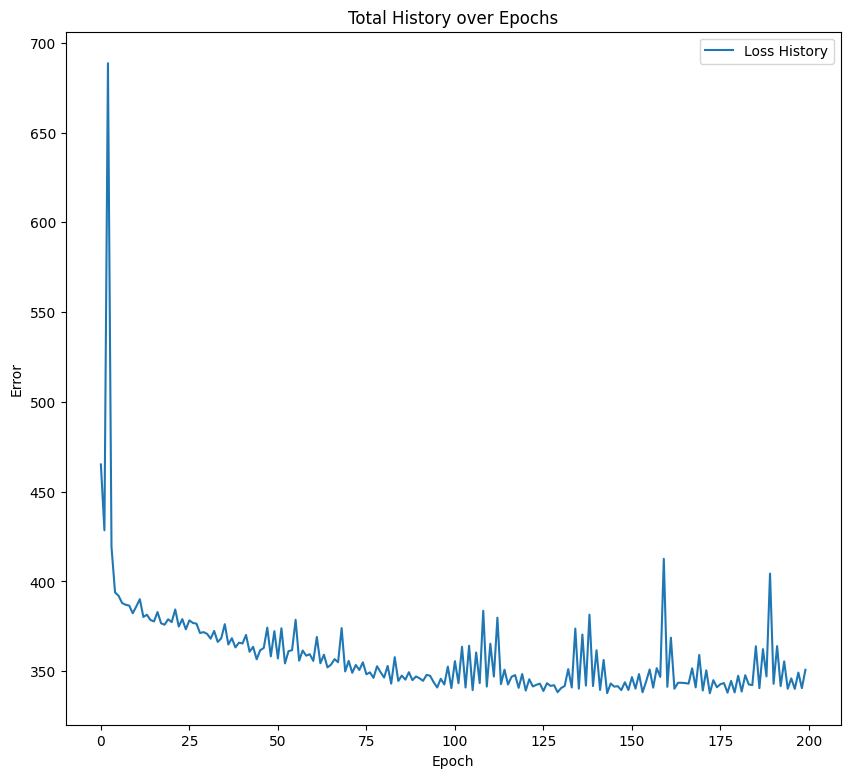

42
[array([[56.29017333]]), array([[54.25055774]]), array([[33.21744329]]), array([[51.42381324]]), array([[36.58822051]]), array([[25.60705984]]), array([[38.59153323]]), array([[51.25288736]]), array([[45.81284971]]), array([[43.29445818]]), array([[58.87819978]]), array([[50.35434145]]), array([[56.09816121]]), array([[40.27171587]]), array([[42.07005477]]), array([[40.90682816]]), array([[46.80896216]]), array([[58.47648369]]), array([[38.08401689]]), array([[57.21785296]]), array([[49.5152389]]), array([[6.554937]]), array([[5.68424575]]), array([[2.48497816]]), array([[3.19851607]]), array([[7.01293804]]), array([[2.89205118]]), array([[5.4457401]]), array([[7.07510379]]), array([[3.96201412]]), array([[7.30797525]]), array([[5.52632125]]), array([[5.95803416]]), array([[1.82393215]]), array([[4.00544425]]), array([[5.13324067]]), array([[2.14787324]]), array([[7.21215841]]), array([[4.76607303]]), array([[6.68479493]]), array([[7.04574906]]), array([[4.29142189]])]
Data to train

Epoch 149/200 - Total Loss: 15105.1573, Recon Loss: 11780.7161, KL Loss: 33244.4116
Epoch 150/200 - Total Loss: 15322.0353, Recon Loss: 11758.2810, KL Loss: 35637.5439
Epoch 151/200 - Total Loss: 15129.3741, Recon Loss: 11742.8480, KL Loss: 33865.2607
Epoch 152/200 - Total Loss: 15266.6773, Recon Loss: 11774.9729, KL Loss: 34917.0443
Epoch 153/200 - Total Loss: 15192.1117, Recon Loss: 11780.2094, KL Loss: 34119.0228
Epoch 154/200 - Total Loss: 15142.7079, Recon Loss: 11747.4467, KL Loss: 33952.6119
Epoch 155/200 - Total Loss: 15157.1453, Recon Loss: 11734.9234, KL Loss: 34222.2188
Epoch 156/200 - Total Loss: 15076.7507, Recon Loss: 11767.7385, KL Loss: 33090.1225
Epoch 157/200 - Total Loss: 15169.9762, Recon Loss: 11766.7611, KL Loss: 34032.1511
Epoch 158/200 - Total Loss: 15300.5844, Recon Loss: 11841.5596, KL Loss: 34590.2480
Epoch 159/200 - Total Loss: 15465.9336, Recon Loss: 11815.0794, KL Loss: 36508.5422
Epoch 160/200 - Total Loss: 15100.9327, Recon Loss: 11755.2229, KL Loss: 334

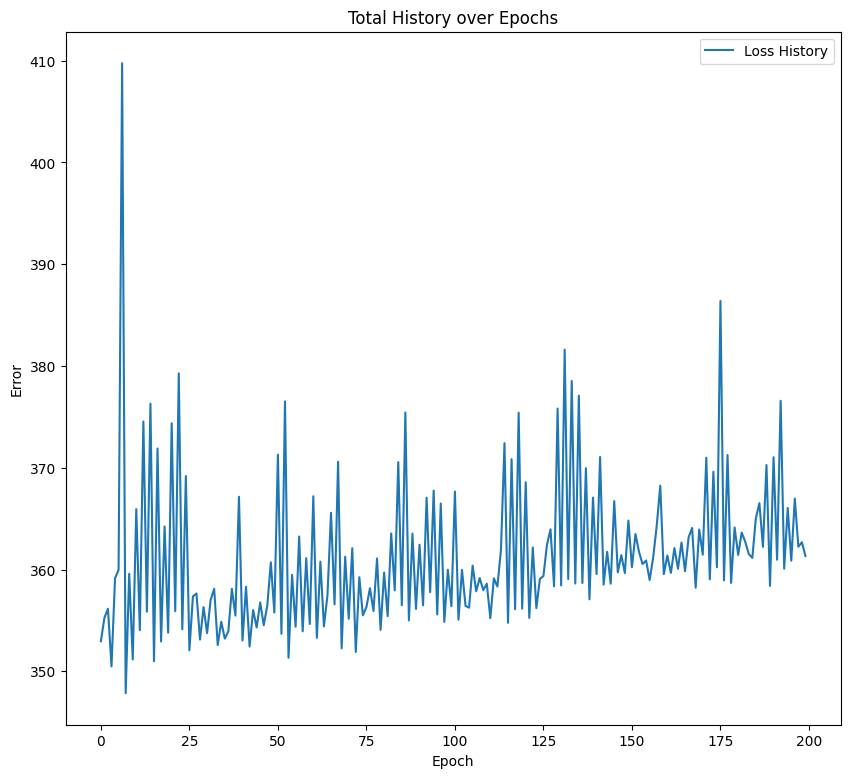

42
[array([[52.82841184]]), array([[49.23039971]]), array([[67.79475034]]), array([[61.08592058]]), array([[45.18912083]]), array([[52.16552528]]), array([[55.51068964]]), array([[47.32038292]]), array([[55.44702505]]), array([[69.02895595]]), array([[52.35613524]]), array([[62.48633595]]), array([[44.78296478]]), array([[66.74869591]]), array([[67.00983628]]), array([[64.40173325]]), array([[59.58951218]]), array([[61.3174684]]), array([[61.80176951]]), array([[58.59506712]]), array([[31.86596468]]), array([[5.14670698]]), array([[3.22045967]]), array([[4.1314204]]), array([[5.80968701]]), array([[5.07522327]]), array([[6.50977491]]), array([[4.64088751]]), array([[5.94368625]]), array([[6.83006167]]), array([[5.98114023]]), array([[6.89754087]]), array([[2.17149689]]), array([[6.14441119]]), array([[5.22906121]]), array([[4.60413709]]), array([[6.21591034]]), array([[3.04387868]]), array([[3.89019063]]), array([[4.56927638]]), array([[4.60983399]]), array([[6.55593599]])]
Data to tra

Epoch 157/200 - Total Loss: 13949.8260, Recon Loss: 11966.4953, KL Loss: 19833.3068
Epoch 158/200 - Total Loss: 14272.7009, Recon Loss: 11947.1117, KL Loss: 23255.8921
Epoch 159/200 - Total Loss: 13967.0397, Recon Loss: 11953.2191, KL Loss: 20138.2066
Epoch 160/200 - Total Loss: 14358.6594, Recon Loss: 12033.8692, KL Loss: 23247.9015
Epoch 161/200 - Total Loss: 14009.5369, Recon Loss: 12085.2713, KL Loss: 19242.6553
Epoch 162/200 - Total Loss: 14857.0870, Recon Loss: 12273.2083, KL Loss: 25838.7866
Epoch 163/200 - Total Loss: 13985.2543, Recon Loss: 12105.8744, KL Loss: 18793.7991
Epoch 164/200 - Total Loss: 15526.5614, Recon Loss: 12702.4982, KL Loss: 28240.6319
Epoch 165/200 - Total Loss: 14018.2872, Recon Loss: 12209.0359, KL Loss: 18092.5129
Epoch 166/200 - Total Loss: 15722.4764, Recon Loss: 12792.2365, KL Loss: 29302.3989
Epoch 167/200 - Total Loss: 14089.8281, Recon Loss: 12235.8335, KL Loss: 18539.9460
Epoch 168/200 - Total Loss: 16095.6901, Recon Loss: 13045.9198, KL Loss: 304

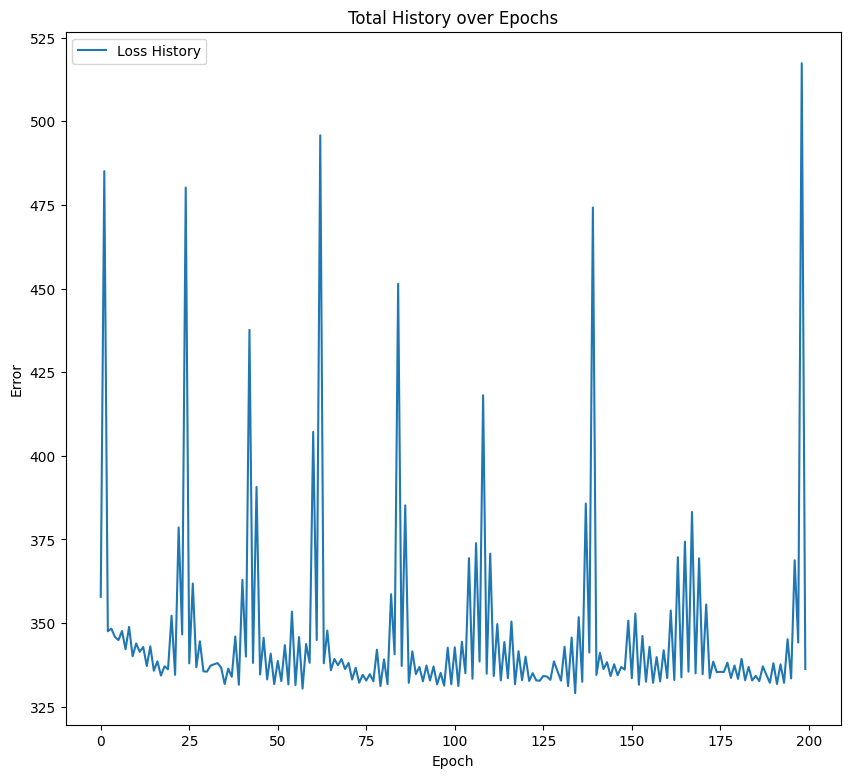

42
[array([[36.2739282]]), array([[49.62090551]]), array([[55.65562542]]), array([[50.83297018]]), array([[63.49693974]]), array([[47.82441928]]), array([[39.77959266]]), array([[72.87668303]]), array([[52.59104143]]), array([[47.09885257]]), array([[44.68920362]]), array([[40.68940312]]), array([[48.03629105]]), array([[42.87205508]]), array([[40.49624667]]), array([[36.05490156]]), array([[42.54062711]]), array([[48.28246169]]), array([[50.01261332]]), array([[44.39705694]]), array([[49.53559613]]), array([[7.45063175]]), array([[8.13569467]]), array([[6.65724288]]), array([[6.02906009]]), array([[4.59212764]]), array([[8.8049195]]), array([[10.22603929]]), array([[7.03530569]]), array([[7.4696277]]), array([[9.670293]]), array([[7.28836937]]), array([[7.5229719]]), array([[8.09758089]]), array([[8.58105245]]), array([[5.27177532]]), array([[8.67760639]]), array([[5.68570388]]), array([[7.31621462]]), array([[9.30332335]]), array([[7.27030051]]), array([[10.72541497]])]
Data to train

Epoch 148/200 - Total Loss: 15194.7302, Recon Loss: 12123.1136, KL Loss: 30716.1654
Epoch 149/200 - Total Loss: 16548.2401, Recon Loss: 12413.4995, KL Loss: 41347.4058
Epoch 150/200 - Total Loss: 15096.7326, Recon Loss: 11921.0772, KL Loss: 31756.5546
Epoch 151/200 - Total Loss: 15260.6066, Recon Loss: 11889.0710, KL Loss: 33715.3555
Epoch 152/200 - Total Loss: 15139.3188, Recon Loss: 11927.4416, KL Loss: 32118.7716
Epoch 153/200 - Total Loss: 15499.5600, Recon Loss: 11958.7035, KL Loss: 35408.5646
Epoch 154/200 - Total Loss: 15138.6571, Recon Loss: 11985.7956, KL Loss: 31528.6151
Epoch 155/200 - Total Loss: 15773.5264, Recon Loss: 12055.3577, KL Loss: 37181.6865
Epoch 156/200 - Total Loss: 15199.9664, Recon Loss: 12002.1797, KL Loss: 31977.8664
Epoch 157/200 - Total Loss: 15737.4864, Recon Loss: 12039.2101, KL Loss: 36982.7635
Epoch 158/200 - Total Loss: 15097.8513, Recon Loss: 11896.5173, KL Loss: 32013.3395
Epoch 159/200 - Total Loss: 15364.6066, Recon Loss: 11924.6700, KL Loss: 343

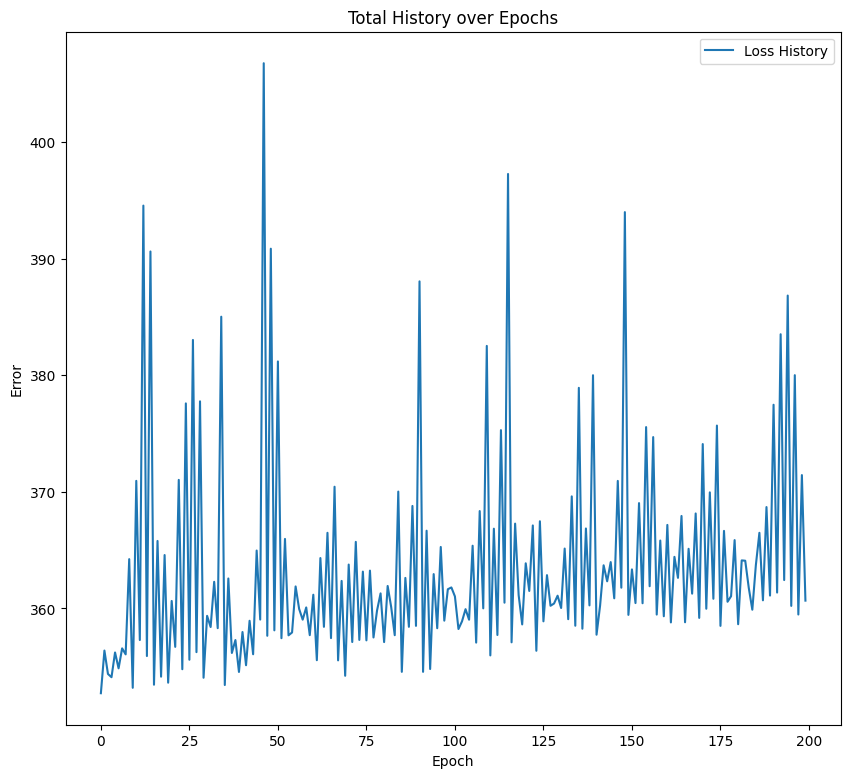

42
[array([[44.84736965]]), array([[52.58352469]]), array([[48.32574892]]), array([[41.11172185]]), array([[42.06312204]]), array([[54.66082485]]), array([[63.15167673]]), array([[59.30009415]]), array([[50.09067907]]), array([[71.11672638]]), array([[64.09398525]]), array([[42.30748544]]), array([[65.64741394]]), array([[75.36034946]]), array([[38.72571933]]), array([[69.85038841]]), array([[38.76115339]]), array([[47.82751694]]), array([[77.83167931]]), array([[65.03058435]]), array([[82.65428981]]), array([[6.62521829]]), array([[12.27604303]]), array([[7.34185809]]), array([[9.46828191]]), array([[7.254704]]), array([[4.15608769]]), array([[9.5136832]]), array([[8.74996596]]), array([[11.2268985]]), array([[4.47849354]]), array([[9.66832428]]), array([[10.02384977]]), array([[5.18927159]]), array([[4.53440304]]), array([[5.21046235]]), array([[7.8809274]]), array([[7.07055066]]), array([[5.70121585]]), array([[7.15309845]]), array([[2.42327039]]), array([[6.96292042]])]
Data to tra

Epoch 148/200 - Total Loss: 15351.0677, Recon Loss: 11852.7499, KL Loss: 34983.1775
Epoch 149/200 - Total Loss: 15310.9294, Recon Loss: 11884.2831, KL Loss: 34266.4628
Epoch 150/200 - Total Loss: 15401.9119, Recon Loss: 11900.2531, KL Loss: 35016.5882
Epoch 151/200 - Total Loss: 15177.5182, Recon Loss: 11871.2593, KL Loss: 33062.5889
Epoch 152/200 - Total Loss: 15216.1671, Recon Loss: 11823.9911, KL Loss: 33921.7602
Epoch 153/200 - Total Loss: 15405.1392, Recon Loss: 11929.4600, KL Loss: 34756.7926
Epoch 154/200 - Total Loss: 15190.6882, Recon Loss: 11819.6713, KL Loss: 33710.1686
Epoch 155/200 - Total Loss: 15423.6905, Recon Loss: 11911.6448, KL Loss: 35120.4569
Epoch 156/200 - Total Loss: 15218.2574, Recon Loss: 11878.2789, KL Loss: 33399.7854
Epoch 157/200 - Total Loss: 15450.9391, Recon Loss: 11900.4212, KL Loss: 35505.1790
Epoch 158/200 - Total Loss: 15214.2029, Recon Loss: 12007.8982, KL Loss: 32063.0469
Epoch 159/200 - Total Loss: 15960.2167, Recon Loss: 12073.4145, KL Loss: 388

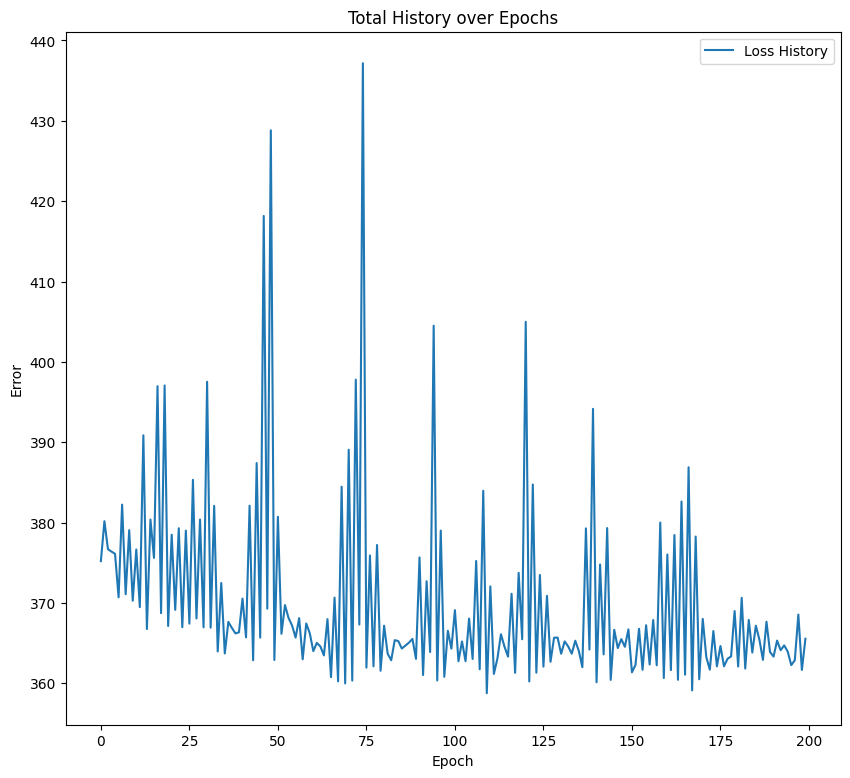

42
[array([[75.47763526]]), array([[66.48806572]]), array([[80.77314363]]), array([[77.07831722]]), array([[72.18937892]]), array([[60.8426099]]), array([[31.1797217]]), array([[54.49548246]]), array([[49.78002137]]), array([[43.35536155]]), array([[37.07414787]]), array([[63.97121366]]), array([[41.14228198]]), array([[62.93451983]]), array([[66.29599014]]), array([[48.38408794]]), array([[38.22622841]]), array([[52.7151731]]), array([[48.71632985]]), array([[50.10871859]]), array([[47.19112639]]), array([[6.77082649]]), array([[1.90243728]]), array([[3.66158626]]), array([[7.95436878]]), array([[5.03194263]]), array([[4.01480257]]), array([[4.26878219]]), array([[3.28943985]]), array([[8.84379547]]), array([[4.78385686]]), array([[5.86734494]]), array([[5.72082168]]), array([[8.71553251]]), array([[3.75420481]]), array([[7.1917239]]), array([[6.1887292]]), array([[5.67728793]]), array([[5.74799786]]), array([[9.11531162]]), array([[6.77136973]]), array([[5.43408765]])]
Data to train:

Epoch 147/200 - Total Loss: 14880.3375, Recon Loss: 11773.7213, KL Loss: 31066.1627
Epoch 148/200 - Total Loss: 15082.6929, Recon Loss: 11769.3720, KL Loss: 33133.2092
Epoch 149/200 - Total Loss: 14967.3857, Recon Loss: 11889.3025, KL Loss: 30780.8322
Epoch 150/200 - Total Loss: 15736.7527, Recon Loss: 11985.6864, KL Loss: 37510.6639
Epoch 151/200 - Total Loss: 14841.5770, Recon Loss: 11754.0097, KL Loss: 30875.6726
Epoch 152/200 - Total Loss: 15094.8248, Recon Loss: 11758.9209, KL Loss: 33359.0392
Epoch 153/200 - Total Loss: 14854.3765, Recon Loss: 11720.9524, KL Loss: 31334.2417
Epoch 154/200 - Total Loss: 15012.3076, Recon Loss: 11760.6201, KL Loss: 32516.8742
Epoch 155/200 - Total Loss: 14949.5521, Recon Loss: 11782.9084, KL Loss: 31666.4369
Epoch 156/200 - Total Loss: 15092.3199, Recon Loss: 11754.1601, KL Loss: 33381.5977
Epoch 157/200 - Total Loss: 14996.9365, Recon Loss: 11732.6931, KL Loss: 32642.4342
Epoch 158/200 - Total Loss: 14935.9751, Recon Loss: 11749.2392, KL Loss: 318

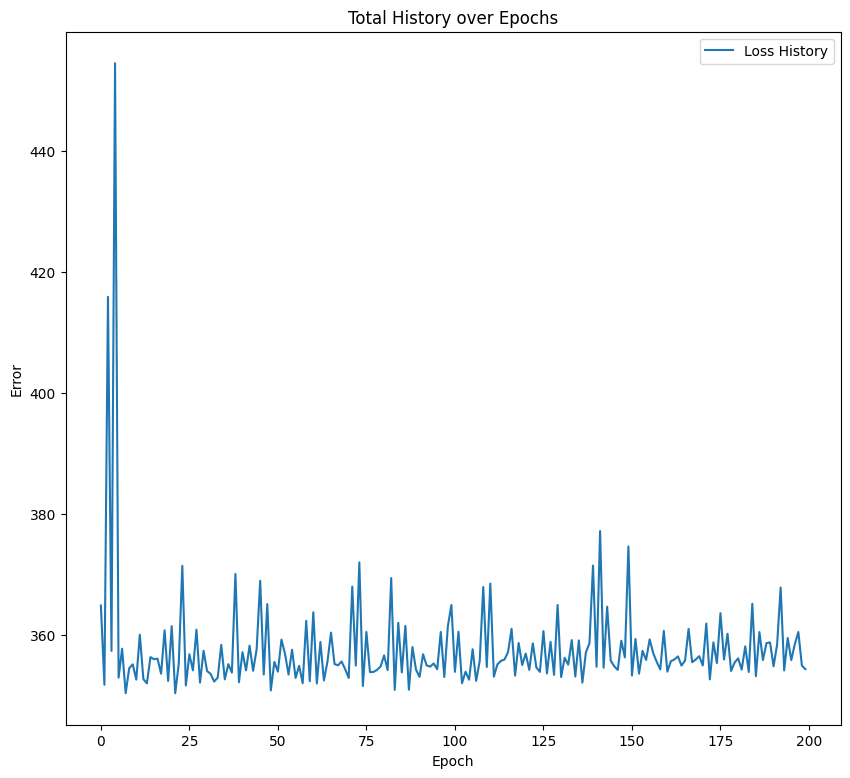

42
[array([[49.75372966]]), array([[48.91758947]]), array([[51.96015241]]), array([[54.82323018]]), array([[57.6388338]]), array([[53.33830338]]), array([[60.4803678]]), array([[46.00493176]]), array([[51.26817087]]), array([[57.38705535]]), array([[51.95287752]]), array([[59.03195087]]), array([[45.34189022]]), array([[58.5871309]]), array([[54.99291433]]), array([[47.98665546]]), array([[54.8085068]]), array([[56.00429925]]), array([[55.06033696]]), array([[63.48412777]]), array([[55.72109013]]), array([[5.6857085]]), array([[6.15430702]]), array([[7.01759341]]), array([[4.76158896]]), array([[5.10032078]]), array([[4.50024739]]), array([[8.37902762]]), array([[10.01881563]]), array([[3.4645751]]), array([[3.74773305]]), array([[3.75513673]]), array([[2.80499475]]), array([[5.60997499]]), array([[5.3945464]]), array([[3.84307375]]), array([[4.23646246]]), array([[5.7246798]]), array([[5.35465004]]), array([[4.10724133]]), array([[10.49956089]]), array([[8.40554711]])]
Data to train: 

Epoch 151/200 - Total Loss: 13774.6521, Recon Loss: 12067.6401, KL Loss: 17070.1202
Epoch 152/200 - Total Loss: 14093.9225, Recon Loss: 12140.8922, KL Loss: 19530.3033
Epoch 153/200 - Total Loss: 13723.3171, Recon Loss: 12034.4685, KL Loss: 16888.4853
Epoch 154/200 - Total Loss: 14253.1980, Recon Loss: 12178.8490, KL Loss: 20743.4900
Epoch 155/200 - Total Loss: 13804.8716, Recon Loss: 12195.2884, KL Loss: 16095.8322
Epoch 156/200 - Total Loss: 15122.8181, Recon Loss: 12716.3545, KL Loss: 24064.6367
Epoch 157/200 - Total Loss: 13981.1176, Recon Loss: 12421.1943, KL Loss: 15599.2331
Epoch 158/200 - Total Loss: 16113.9078, Recon Loss: 13319.7465, KL Loss: 27941.6125
Epoch 159/200 - Total Loss: 13853.7171, Recon Loss: 12272.5624, KL Loss: 15811.5467
Epoch 160/200 - Total Loss: 14816.7683, Recon Loss: 12448.6069, KL Loss: 23681.6140
Epoch 161/200 - Total Loss: 13955.3432, Recon Loss: 12268.5752, KL Loss: 16867.6801
Epoch 162/200 - Total Loss: 14685.2435, Recon Loss: 12372.0980, KL Loss: 231

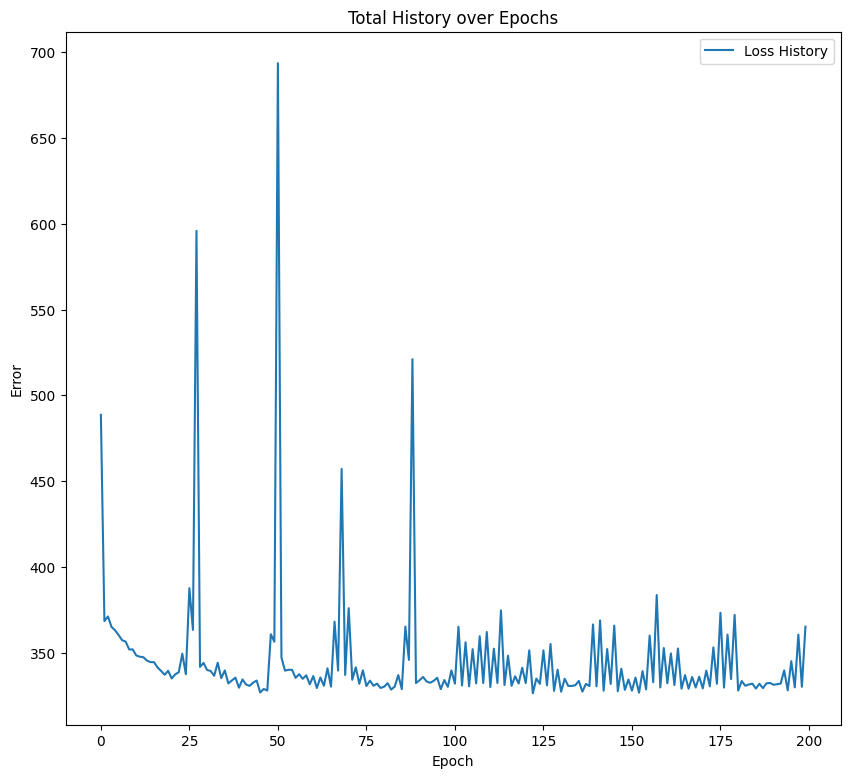

42
[array([[47.98720279]]), array([[43.75180773]]), array([[36.55235203]]), array([[42.63899285]]), array([[37.68644239]]), array([[39.19961011]]), array([[43.29046948]]), array([[36.38009715]]), array([[51.18245089]]), array([[32.85520177]]), array([[37.15462417]]), array([[33.56373971]]), array([[35.68239013]]), array([[45.34627867]]), array([[34.94089661]]), array([[43.33544529]]), array([[30.66672946]]), array([[42.46377754]]), array([[39.61486793]]), array([[45.64875825]]), array([[41.41125242]]), array([[3.98822827]]), array([[4.87360991]]), array([[4.2337074]]), array([[4.29594438]]), array([[7.39245909]]), array([[5.06304998]]), array([[8.72077014]]), array([[3.30079379]]), array([[1.27554027]]), array([[3.15158758]]), array([[3.91943162]]), array([[2.60288256]]), array([[1.43980443]]), array([[5.54784724]]), array([[0.4590711]]), array([[2.41292516]]), array([[5.30118891]]), array([[4.46227915]]), array([[8.04480199]]), array([[2.58890271]]), array([[6.33964143]])]
Data to tra

Epoch 149/200 - Total Loss: 14888.7645, Recon Loss: 12095.5578, KL Loss: 27932.0672
Epoch 150/200 - Total Loss: 14217.1841, Recon Loss: 11992.9751, KL Loss: 22242.0893
Epoch 151/200 - Total Loss: 14929.3666, Recon Loss: 12134.6234, KL Loss: 27947.4314
Epoch 152/200 - Total Loss: 14233.1534, Recon Loss: 11967.2212, KL Loss: 22659.3226
Epoch 153/200 - Total Loss: 14741.0134, Recon Loss: 12004.5043, KL Loss: 27365.0904
Epoch 154/200 - Total Loss: 14290.5129, Recon Loss: 11972.9469, KL Loss: 23175.6597
Epoch 155/200 - Total Loss: 14638.2194, Recon Loss: 11943.4773, KL Loss: 26947.4211
Epoch 156/200 - Total Loss: 14290.6116, Recon Loss: 11908.6835, KL Loss: 23819.2806
Epoch 157/200 - Total Loss: 14848.8897, Recon Loss: 12102.0563, KL Loss: 27468.3340
Epoch 158/200 - Total Loss: 14121.6647, Recon Loss: 11920.6798, KL Loss: 22009.8485
Epoch 159/200 - Total Loss: 14743.2629, Recon Loss: 12014.1452, KL Loss: 27291.1774
Epoch 160/200 - Total Loss: 14199.6671, Recon Loss: 11859.7917, KL Loss: 233

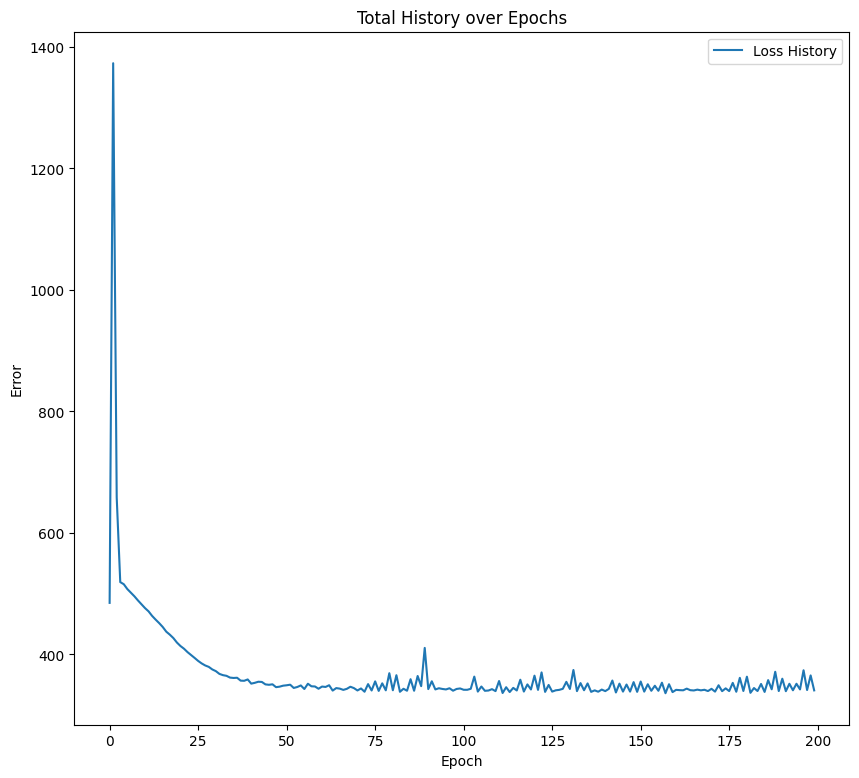

42
[array([[61.01517381]]), array([[47.53949007]]), array([[44.88622931]]), array([[75.68870809]]), array([[57.40566297]]), array([[46.41806223]]), array([[63.71087743]]), array([[40.52453825]]), array([[49.33672239]]), array([[50.74225626]]), array([[47.74861734]]), array([[58.61140162]]), array([[44.32051207]]), array([[53.72881997]]), array([[45.39444781]]), array([[43.00676093]]), array([[47.01037623]]), array([[60.65997836]]), array([[47.80556662]]), array([[54.37147155]]), array([[36.6080122]]), array([[8.62166665]]), array([[9.17247784]]), array([[5.89791212]]), array([[6.53880264]]), array([[9.66210205]]), array([[10.4349873]]), array([[9.16894122]]), array([[6.49625763]]), array([[8.57771983]]), array([[8.14448128]]), array([[11.03482104]]), array([[7.08542309]]), array([[7.81749161]]), array([[7.13528889]]), array([[5.56374342]]), array([[5.77803822]]), array([[7.84469882]]), array([[9.44944918]]), array([[8.60205833]]), array([[5.21112907]]), array([[7.87831748]])]


In [27]:
# Train the VAE
epochs = 200
learning_rate = 0.0001
# print(data_good_wafer.shape)
# print(label_good_wafer.shape)

latent_val_good = []
latent_val_bad = []

for i in range(22):
    good_training_step = 21
    bad_training_step = 21

    bad_wafer_df = training_df[ (training_df['failureType'] != 'none')]
    good_wafer_df = training_df[ (training_df['failureType'] == 'none')]
    bad_wafer_df = bad_wafer_df[bad_wafer_df['waferMap'].apply(lambda x: filter_condition(x, 'bad'))]
    good_wafer_df = good_wafer_df[good_wafer_df['waferMap'].apply(lambda x: filter_condition(x, 'good'))]

    # Label data for bad wafer
    label_bad_wafer = np.tile(base_bad_valid,(bad_training_step,1))

    # Label data for good wafer
    label_good_wafer = np.tile(base_good_valid,(good_training_step,1))

    bad_wafer_df = bad_wafer_df[bad_training_step*i:bad_training_step * (i+1)] 
    good_wafer_df = good_wafer_df[good_training_step*i:good_training_step * (i+1)]

    # Scale all image to asme dimension then flatten it to single row
    data_bad_wafer = np.stack(bad_wafer_df['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
    data_bad_wafer[data_bad_wafer>2] = 2

    data_good_wafer = np.stack(good_wafer_df['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
    data_good_wafer[data_good_wafer>2] = 2

    label_train = np.concatenate((label_bad_wafer, label_good_wafer), axis=0)
    data_train = np.concatenate((data_bad_wafer, data_good_wafer), axis=0)

    label_train = np.where(label_train == 0, 0 , np.where(label_train == 1, 0.5, 1))
    data_train = np.where(data_train == 0, 0 , np.where(data_train == 1, 0.5, 1))
    
    curr_val_latent = vae.train(data_train, label_train, epochs, learning_rate)
    print(len(curr_val_latent))
    print(curr_val_latent)
    latent_val_bad.append(curr_val_latent[:bad_training_step])
    latent_val_good.append(curr_val_latent[bad_training_step:])

### Visualizing Latent Values

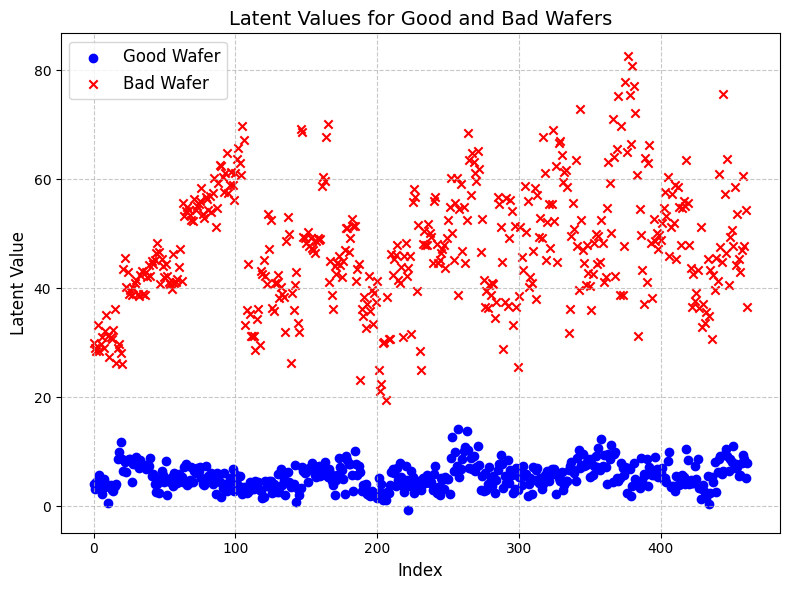

In [28]:
latent_bad_wafer = np.concatenate([np.concatenate(sublist).flatten() for sublist in latent_val_bad])
latent_good_wafer = np.concatenate([np.concatenate(sublist).flatten() for sublist in latent_val_good])

def plot_latent(good_latent,bad_latent):
    plt.figure(figsize=(8, 6))

    # Plot good wafers with 'o'
    plt.scatter(range(len(good_latent)), good_latent, marker='o', color='blue', label='Good Wafer')

    # Plot bad wafers with 'x'
    plt.scatter(range(len(bad_latent)), bad_latent, marker='x', color='red', label='Bad Wafer')

    # Adding labels, legend, and title
    plt.xlabel("Index", fontsize=12)
    plt.ylabel("Latent Value", fontsize=12)
    plt.title("Latent Values for Good and Bad Wafers", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Display the plot
    plt.tight_layout()
    plt.show()

plot_latent(latent_good_wafer,latent_bad_wafer)

#### Get Params

In [29]:
param_W_enc, param_B_enc, param_W_mu, param_B_mu, param_W_var, param_B_var, param_W_dec, param_B_dec, param_W_out, param_B_out = vae.get_train_param()

(2048, 1)


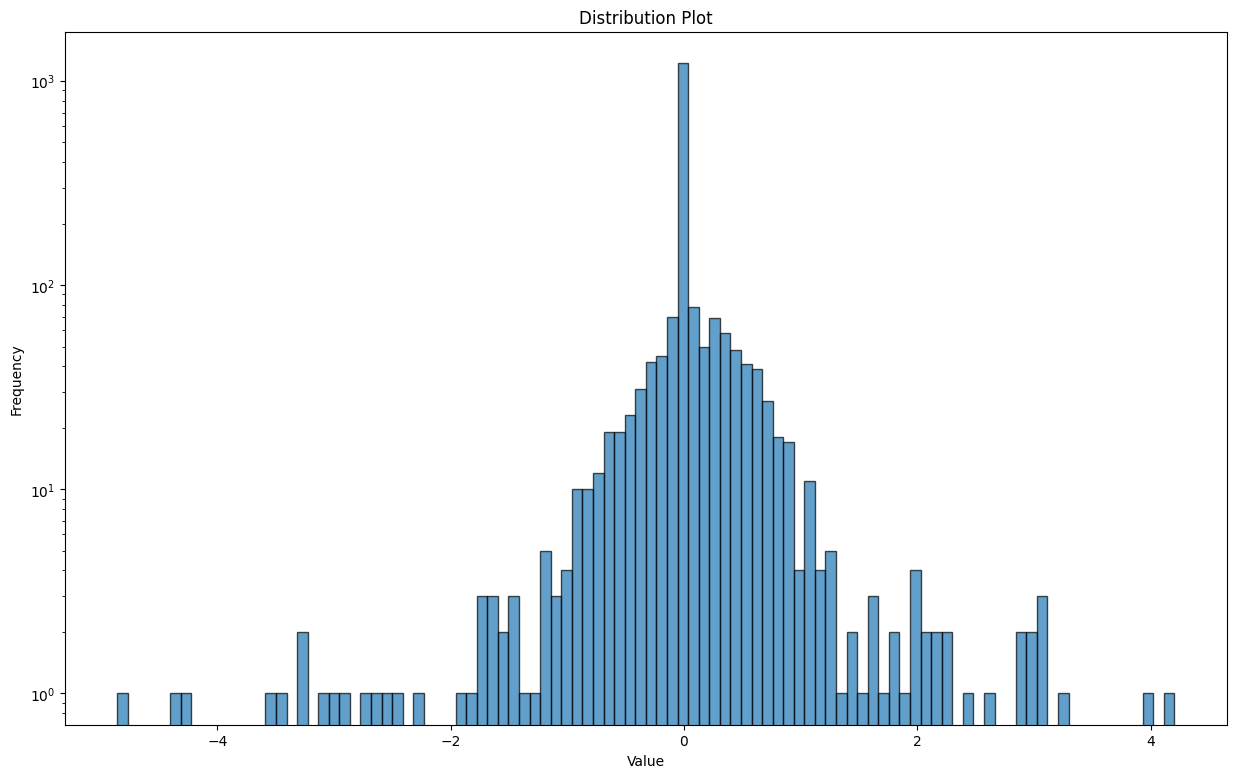

In [30]:
all_weight = np.concatenate((param_W_mu,param_W_var))
print(all_weight.shape)
# Create the distribution plot
plt.figure(figsize=(15,9))
plt.hist(all_weight, bins=100, edgecolor='black', alpha=0.7,log=True)  # Adjust the number of bins as needed

# Label axes
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution Plot')
# Show the plot
plt.show()

### Export Weight, Bias, and Input to txt

#### Float to Fixed Point and Vice versa Converters

In [31]:
def float_to_fp(value, total_bits=16, frac_bits=8, output_format='hex'):
    # Step 1: Check if the value is negative
    if value < 0:
        is_negative = True
        value = -value  # Work with the positive equivalent for conversion
    else:
        is_negative = False

    # Step 2: Multiply the float by 2^frac_bits to scale it
    scaled_value = round(value * (2 ** frac_bits))
    
    # Step 3: Convert the scaled value to a binary string
    # Format the binary string to the required total bits length
    binary_value = bin(scaled_value)[2:].zfill(total_bits)
    # print(f'Scaled Value: {scaled_value}')
    # print(f'Binary Value: {binary_value}')

    # Step 4: Handle the negative case
    if is_negative:
        # Perform two's complement conversion for negative numbers
        # Subtract the binary value from the max value for two's complement
        max_value = (1 << total_bits)  # This is 2^total_bits
        binary_value = bin(max_value - scaled_value)[2:].zfill(total_bits)
        neg_bit_length = len(binary_value)
        if neg_bit_length > total_bits: binary_value = binary_value[neg_bit_length-total_bits:]

    # Step 5: Convert the binary value to hexadecimal
    hex_value = hex(int(binary_value, 2))[2:].zfill(total_bits // 4)  # Convert to hex and remove '0x'

    # Step 6: Format output based on the `output_format` argument
    if output_format == 'binary':
        return binary_value
    elif output_format == 'hex':
        return hex_value
    elif output_format == 'both':
        return (f"{total_bits}'b{binary_value}", f"{total_bits}'h{hex_value}")
    else:
        raise ValueError("Invalid output format. Choose 'binary', 'hex', or 'both'.")
    
def fp_to_float(value,total_bits=16, frac_bits=8, input_format='hex'):
    if input_format == 'binary': fp_val = int(value,2)
    elif input_format == 'hex': fp_val = int(value,16)
    else: raise ValueError("Invalid input format. Must be 'binary' or 'hex'")
    # Calculate the scaling factor: 2^frac_width
    scaling_factor = 2 ** frac_bits
    # Handle two's complement if the sign bit is set (for negative numbers)
    sign_bit_mask = 1 << (total_bits - 1)  # Mask to isolate the sign bit
    
    # Check if the value is negative by examining the sign bit
    if fp_val & sign_bit_mask:  # If sign bit is 1, it's negative
        # Convert from two's complement
        fp_val = fp_val - (1 << total_bits)  # Apply the two's complement adjustment
    
    # Convert to float by dividing by the scaling factor
    float_value = fp_val / scaling_factor
    
    return float_value

# Example usage:
value = 64  # Example float number

num1 = float_to_fp(value)
inv_num1 = fp_to_float(str(num1))
print(num1,inv_num1)

4000 64.0


#### Exporting Weight and Bias to txt

In [32]:
def wr_to_file(np_arr,filename):
    with open(filename, 'w') as f:
        for val in np_arr:
            data = float_to_fp(val[0])
            f.write(data + '\n')

wr_to_file(param_W_mu,"data_tb\\weight_mu.txt")
wr_to_file(param_W_var,"data_tb\\weight_var.txt")
wr_to_file(param_B_mu, "data_tb\\bias_mu.txt")
wr_to_file(param_B_var, "data_tb\\bias_var.txt")

# Edit txt to teffandi's format
# Define function to reorder lines in intervals of 128
def reorder_lines(input_file, output_file):
    # Read all lines from input file
    with open(input_file, 'r') as file:
        lines = file.readlines()
    
    # Check if the file has exactly 1024 lines
    if len(lines) != 1024:
        print(f"Error: The file should contain exactly 1024 lines, but it contains {len(lines)} lines.")
        return
    
    # Initialize list to hold reordered lines
    reordered_lines = [""] * 1024
    
    # Reorder lines in intervals of 128
    temp = 0
    for i in range(0,128):
        for j in range (0,8):
            interval_lines = lines[i+j*127]
            reordered_lines[temp] = str(interval_lines)
            temp = temp + 1
    
    # Write reordered lines to output file
    with open(output_file, 'w') as file:
        file.writelines(reordered_lines)

# Use the function to reorder lines from 'input.txt' to 'output.txt'
reorder_lines("data_tb\\weight_mu.txt", "data_tb\\mu.txt")
reorder_lines("data_tb\\weight_var.txt", "data_tb\\var.txt")

#### Exporting Input to txt

In [33]:
print(len(data_train))
print(data_train[1][1])
for i in range(3):
    print(i)

42
0.0
0
1
2


In [34]:
# export as 2 bit

data_train[0]

print(float_to_fp(0,total_bits=2,frac_bits=1,output_format='binary'))


def image_data_txt(np_arr, fn1, fn2, fn3, fn4):
    f1 = open(fn1,'w'); f2 = open(fn2, 'w')
    f3 = open(fn3,'w'); f4 = open(fn4, 'w')

    for idx in range(len(data_train[0])//(32*4)):
        data1 = []; data2 = []; data3 = []; data4 = [];
        idx1 = idx * 128
        idx2 = 32+ idx1
        idx3 = 32+ idx2
        idx4 = 32+ idx3
        fin_idx = 32 + idx4
        
        for i in range(idx2-1,idx1-1,-1): data1.append(float_to_fp(np_arr[i],total_bits=2,frac_bits=1, output_format='binary'))
        for i in range(idx3-1,idx2-1,-1): data2.append(float_to_fp(np_arr[i],total_bits=2,frac_bits=1, output_format='binary'))
        for i in range(idx4-1,idx3-1,-1): data3.append(float_to_fp(np_arr[i],total_bits=2,frac_bits=1, output_format='binary'))
        for i in range(fin_idx-1,idx4-1,-1): data4.append(float_to_fp(np_arr[i],total_bits=2,frac_bits=1, output_format='binary'))

        f1.write(''.join(data1) + '\n')
        f2.write(''.join(data2) + '\n')
        f3.write(''.join(data3) + '\n')
        f4.write(''.join(data4) + '\n')

    f1.close(); f2.close(); f3.close(); f4.close()

fn1 = "..\\rtl_dev_teffandi\\input_bad1.txt"
fn2 = "..\\rtl_dev_teffandi\\input_bad2.txt"
fn3 = "..\\rtl_dev_teffandi\\input_bad3.txt"
fn4 = "..\\rtl_dev_teffandi\\input_bad4.txt"

np_arr = data_train[0]
image_data_txt(np_arr, fn1, fn2, fn3, fn4)

# Full data
def all_image_data_txt(np_arr, fn1, fn2, fn3, fn4):
    f1 = open(fn1,'w'); f2 = open(fn2, 'w')
    f3 = open(fn3,'w'); f4 = open(fn4, 'w')

    for j in range (len(np_arr)):
        for idx in range(len(data_train[j])//(32*4)):
            data1 = []; data2 = []; data3 = []; data4 = [];
            idx1 = idx * 128
            idx2 = 32+ idx1
            idx3 = 32+ idx2
            idx4 = 32+ idx3
            fin_idx = 32 + idx4

            for i in range(idx2-1,idx1-1,-1): data1.append(float_to_fp(np_arr[j][i],total_bits=2,frac_bits=1, output_format='binary'))
            for i in range(idx3-1,idx2-1,-1): data2.append(float_to_fp(np_arr[j][i],total_bits=2,frac_bits=1, output_format='binary'))
            for i in range(idx4-1,idx3-1,-1): data3.append(float_to_fp(np_arr[j][i],total_bits=2,frac_bits=1, output_format='binary'))
            for i in range(fin_idx-1,idx4-1,-1): data4.append(float_to_fp(np_arr[j][i],total_bits=2,frac_bits=1, output_format='binary'))

            f1.write(''.join(data1) + '\n')
            f2.write(''.join(data2) + '\n')
            f3.write(''.join(data3) + '\n')
            f4.write(''.join(data4) + '\n')

    f1.close(); f2.close(); f3.close(); f4.close()
    
fnn1 = "..\\rtl_dev_teffandi\\input1.txt"
fnn2 = "..\\rtl_dev_teffandi\\input2.txt"
fnn3 = "..\\rtl_dev_teffandi\\input3.txt"
fnn4 = "..\\rtl_dev_teffandi\\input4.txt"


all_image_data_txt(data_train, fnn1, fnn2, fnn3, fnn4)

00


### Confusion Matrix

Threshold Range: 0.8889321381301665 to 10.21608563192897

Confusion Matrix:
                                         Actual Good Wafer    Actual Bad Wafer    
Predicted Good Wafer                     444                  0                   
Predicted Bad Wafer                      18                   462                 


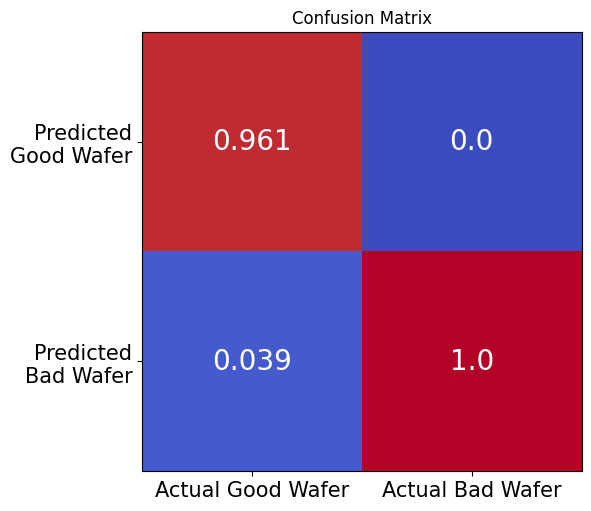

In [35]:
# latent_good_wafer = latent_val[train_max_row:]
# latent_bad_wafer = latent_val[:train_max_row]
# Compute mean and std for good wafer latent values
good_mean = np.mean(latent_good_wafer)
good_std = np.std(latent_good_wafer)

# Define thresholds
threshold_lower = good_mean - 2 * good_std
threshold_upper = good_mean + 2 * good_std

print(f"Threshold Range: {threshold_lower} to {threshold_upper}")

# Classify each latent value
def classify(np_arr, low_threshold, up_threshold):
    good_elems = np.sum((np_arr >= low_threshold) & (np_arr <= up_threshold))
    return good_elems, len(np_arr)-good_elems

bad_wafer_good_detection, bad_wafer_bad_detection = classify(latent_bad_wafer, threshold_lower, threshold_upper)
good_wafer_good_detection, good_wafer_bad_detection = classify(latent_good_wafer, threshold_lower, threshold_upper)

total_bad_testing_data = len(latent_bad_wafer)
total_good_testing_data = len(latent_good_wafer)

table = np.array([
    ["",    "Actual Good Wafer", "Actual Bad Wafer"],
    ["Predicted Good Wafer", good_wafer_good_detection, bad_wafer_good_detection],
    ["Predicted Bad Wafer", good_wafer_bad_detection, bad_wafer_bad_detection]
])

# Display the table
print("\nConfusion Matrix:")
print("{:<40} {:<20} {:<20}".format(*table[0]))  # Header row
for row in table[1:]:
    print("{:<40} {:<20} {:<20}".format(*row))  # Data rows

confusion_matrix = np.array([
    [np.round(good_wafer_good_detection/total_good_testing_data,4), np.round(bad_wafer_good_detection/total_bad_testing_data,4)],  # Predicted Good: Actual Good, Actual Bad
    [np.round(good_wafer_bad_detection/total_good_testing_data,4), np.round(bad_wafer_bad_detection/total_bad_testing_data,4)]   # Predicted Bad: Actual Good, Actual Bad
])

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(confusion_matrix, cmap="coolwarm")

# Adding labels
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(["Actual Good Wafer", "Actual Bad Wafer"], fontsize=15)
ax.set_yticklabels(["Predicted\nGood Wafer", "Predicted\nBad Wafer"], fontsize=15)

# Rotating tick labels for better readability
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Adding text annotations with text wrapping
for i in range(2):
    for j in range(2):
        ax.text(j, i, str(confusion_matrix[i, j]), ha="center", va="center", color="white", fontsize=20)

# Title and display
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()

## Testing to More Data

### Extract Data Testing

In [36]:
max_shape = (40,40)
target_shape = (32,32)
strClass_trainTestLaebl_df = df[df['trainTestLabel'].apply(lambda x: isinstance(x, str))]
limited_df = sizeLimit_df(strClass_trainTestLaebl_df,max_shape,True)
testing_df = limited_df[(limited_df['trainTestLabel'] == 'Training') | (limited_df['trainTestLabel'] == 'Test')]
# testing_df = limited_df[(limited_df['trainTestLabel'] == 'Training') ]

actual_bad_wafer_df = testing_df[(testing_df['failureType'] != 'none')]
actual_good_wafer_df = testing_df[(testing_df['failureType'] == 'none')]

# Function to filter very bad data
def filter_condition(np_arr, wafer_type):
    count_0 = np.sum(np_arr == 0)  # Count occurrences of 1
    count_1 = np.sum(np_arr == 1)  # Count occurrences of 1
    count_2 = np.sum(np_arr == 2)  # Count occurrences of 2
    if wafer_type == 'bad': return (count_2 > 1.5 * count_1) & (count_0 < count_1)  # Check if count of 2 is less than 20% of count of 1
    else: return (count_2 < 0.05 * count_1) & (count_0 < count_1)  # Check if count of 2 is less than 20% of count of 1

actual_bad_wafer_df = actual_bad_wafer_df[actual_bad_wafer_df['waferMap'].apply(lambda x: filter_condition(x, 'bad'))]
actual_good_wafer_df = actual_good_wafer_df[actual_good_wafer_df['waferMap'].apply(lambda x: filter_condition(x, 'good'))]

# Get numpy array of actual data
actual_bad_wafer_data = np.stack(actual_bad_wafer_df['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
actual_good_wafer_data = np.stack(actual_good_wafer_df['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())

actual_bad_wafer_data = actual_bad_wafer_data[:]
actual_good_wafer_data = actual_good_wafer_data[:]

# Prevent data more than 2
actual_bad_wafer_data[actual_bad_wafer_data>2] = 2
actual_good_wafer_data[actual_good_wafer_data>2] = 2

# Rescale data to 0 to 1
actual_bad_wafer_data = np.where(actual_bad_wafer_data == 0, 0 , np.where(actual_bad_wafer_data == 1, 0.5, 1))
actual_good_wafer_data = np.where(actual_good_wafer_data == 0, 0 , np.where(actual_good_wafer_data == 1, 0.5, 1))

print(actual_bad_wafer_data.shape)
print(actual_good_wafer_data.shape)

(103, 1024)
(3401, 1024)


### Input Data to Model and Visualize Scatter

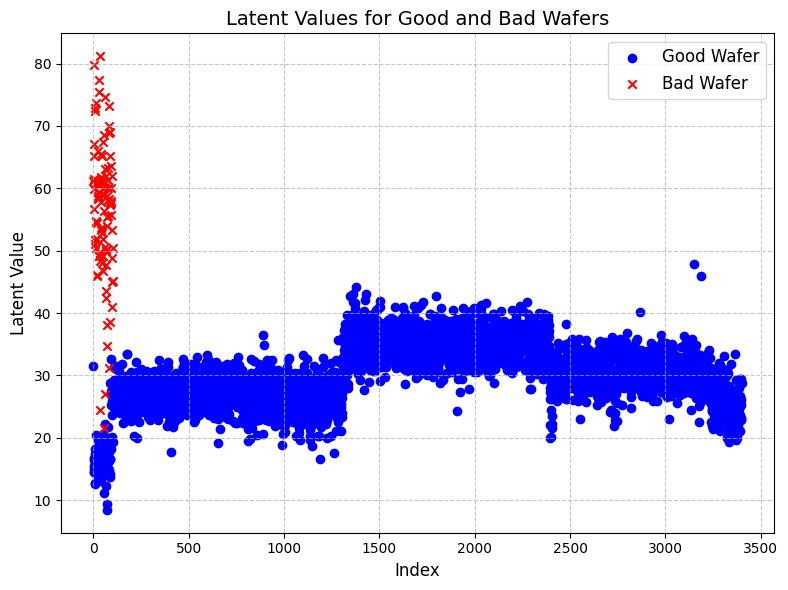

In [37]:
# Testing bad wafer data
def test_data(data_to_test):
    tested_latent_val = []
    for x in data_to_test:
        x = x.reshape(1, -1)
        _, _, _, curr_latent_val, _, _ = vae.forward(x)
        tested_latent_val.append(curr_latent_val)
    return tested_latent_val

latent_predicted_bad_wafer_data = test_data(actual_bad_wafer_data)
latent_predicted_good_wafer_data = test_data(actual_good_wafer_data)

# Compute mean and std for good wafer latent values
good_mean = np.mean(latent_predicted_good_wafer_data)
good_std = np.std(latent_predicted_good_wafer_data)

# Define thresholds
threshold_lower = good_mean - 2 * good_std
threshold_upper = good_mean + 2 * good_std

# Plot latent values
plot_latent(latent_predicted_good_wafer_data, latent_predicted_bad_wafer_data)

### Confusion Matrix of More Data Testing

Threshold Range: 20.00156329131286 to 40.21453425832003

Confusion Matrix:
                                         Actual Good Wafer    Actual Bad Wafer    
Predicted Good Wafer                     3256                 7                   
Predicted Bad Wafer                      145                  96                  


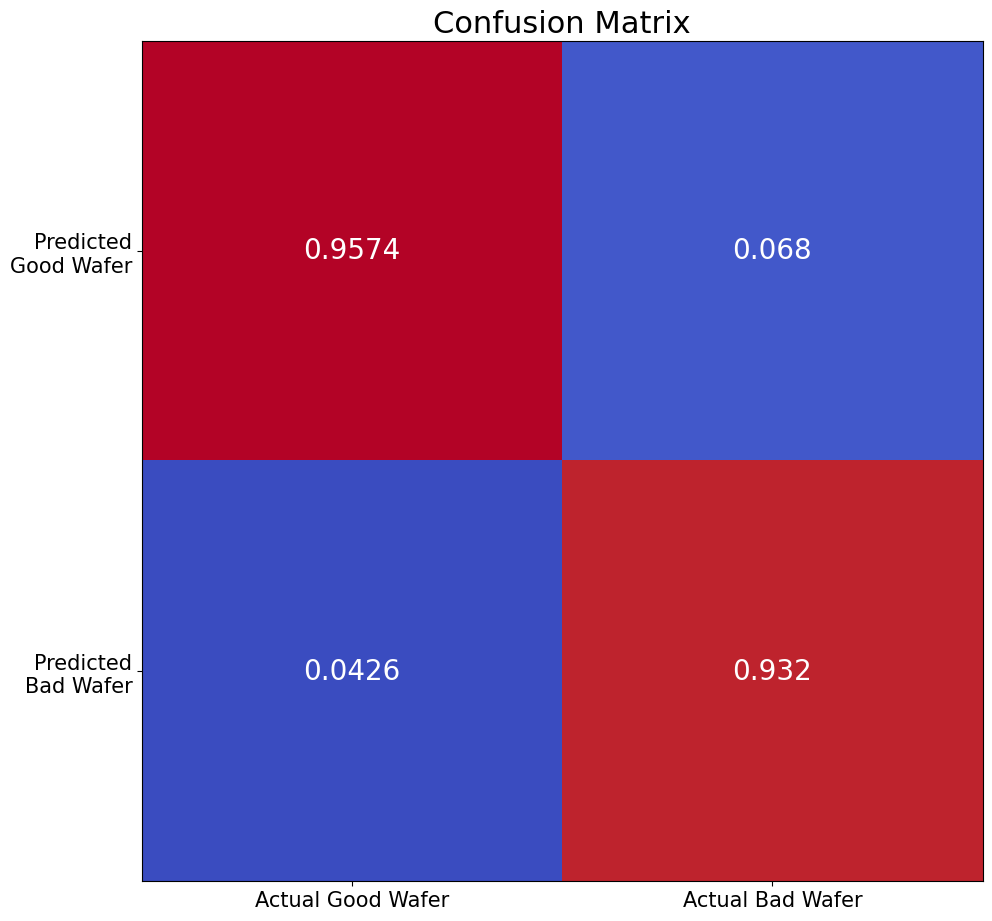

In [38]:
print(f"Threshold Range: {threshold_lower} to {threshold_upper}")

# Classify each latent value
def classify(np_arr, low_threshold, up_threshold):
    good_elems = np.sum((np_arr >= low_threshold) & (np_arr <= up_threshold))
    return good_elems, len(np_arr)-good_elems

good_wafer_good_detection, good_wafer_bad_detection = classify(latent_predicted_good_wafer_data, threshold_lower, threshold_upper)
bad_wafer_good_detection, bad_wafer_bad_detection = classify(latent_predicted_bad_wafer_data, threshold_lower, threshold_upper)

total_bad_testing_data = len(latent_predicted_bad_wafer_data)
total_good_testing_data = len(latent_predicted_good_wafer_data)

table = np.array([
    ["",    "Actual Good Wafer", "Actual Bad Wafer"],
    ["Predicted Good Wafer", good_wafer_good_detection, bad_wafer_good_detection],
    ["Predicted Bad Wafer", good_wafer_bad_detection, bad_wafer_bad_detection]
])

# Display the table
print("\nConfusion Matrix:")
print("{:<40} {:<20} {:<20}".format(*table[0]))  # Header row
for row in table[1:]:
    print("{:<40} {:<20} {:<20}".format(*row))  # Data rows

confusion_matrix = np.array([
    [np.round(good_wafer_good_detection/total_good_testing_data,4), np.round(bad_wafer_good_detection/total_bad_testing_data,4)],  # Predicted Good: Actual Good, Actual Bad
    [np.round(good_wafer_bad_detection/total_good_testing_data,4), np.round(bad_wafer_bad_detection/total_bad_testing_data,4)]   # Predicted Bad: Actual Good, Actual Bad
])

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(confusion_matrix, cmap="coolwarm")

# Adding labels
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(["Actual Good Wafer", "Actual Bad Wafer"], fontsize=15)
ax.set_yticklabels(["Predicted\nGood Wafer", "Predicted\nBad Wafer"], fontsize=15)

# Rotating tick labels for better readability
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Adding text annotations with text wrapping
for i in range(2):
    for j in range(2):
        ax.text(j, i, str(confusion_matrix[i, j]), ha="center", va="center", color="white", fontsize=20)

# Title and display
ax.set_title("Confusion Matrix", fontsize=22)
plt.tight_layout()
plt.show()

In [144]:
result_tb = []
with open("data_tb\\result.txt", 'r') as file:
    for line in file:
        result_tb.append(fp_to_float(line.strip(),total_bits=16, frac_bits=8, input_format='hex'))
resulttb = np.array(result_tb)
print(resulttb)
# Compute mean and std for good wafer latent values
good_mean = np.mean(resulttb[21:42])
good_std = np.std(resulttb[21:42])

# Define thresholds
threshold_lower = good_mean - 2 * good_std
threshold_upper = good_mean + 2 * good_std
good, bad = classify(resulttb, threshold_lower, threshold_upper)
print("Good: " + str(good))
print("Bad: " + str(bad))

[-60.5625     -49.92578125 -47.81640625 -63.4296875  -47.515625
 -50.09765625 -66.1328125  -45.8046875  -53.48046875 -48.93359375
 -42.93359375 -53.921875   -49.73828125 -49.26953125 -42.48046875
 -42.37890625 -52.87109375 -51.015625   -38.20703125 -52.94140625
 -59.421875   -32.29296875 -29.72265625 -33.79296875 -33.8125
 -33.33984375 -33.14453125 -30.50390625 -32.18359375 -29.9453125
 -33.35546875 -33.51953125 -33.61328125 -32.44921875 -33.71484375
 -32.9453125  -31.86328125 -36.69921875 -35.68359375 -32.56640625
 -34.92578125 -37.47265625]
Good: 20
Bad: 22


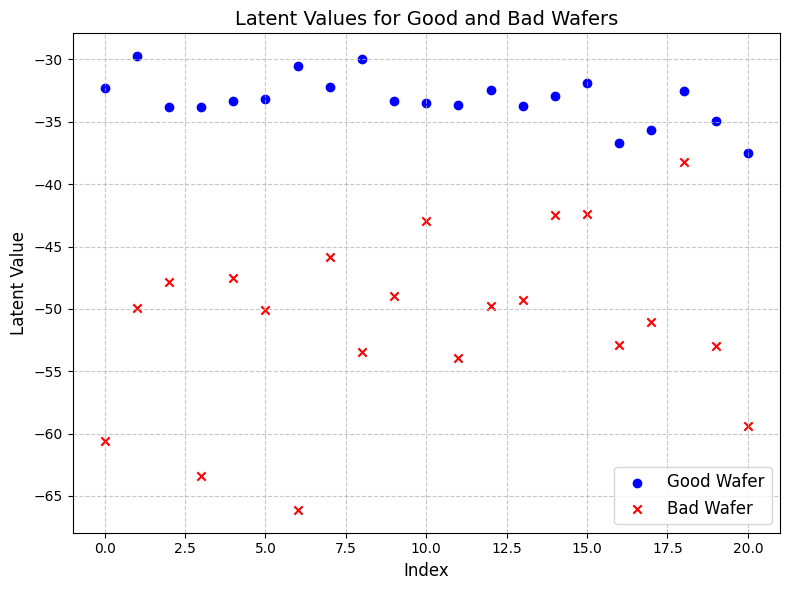


Confusion Matrix:
                                         Actual Good Wafer    Actual Bad Wafer    
Predicted Good Wafer                     20                   0                   
Predicted Bad Wafer                      1                    21                  


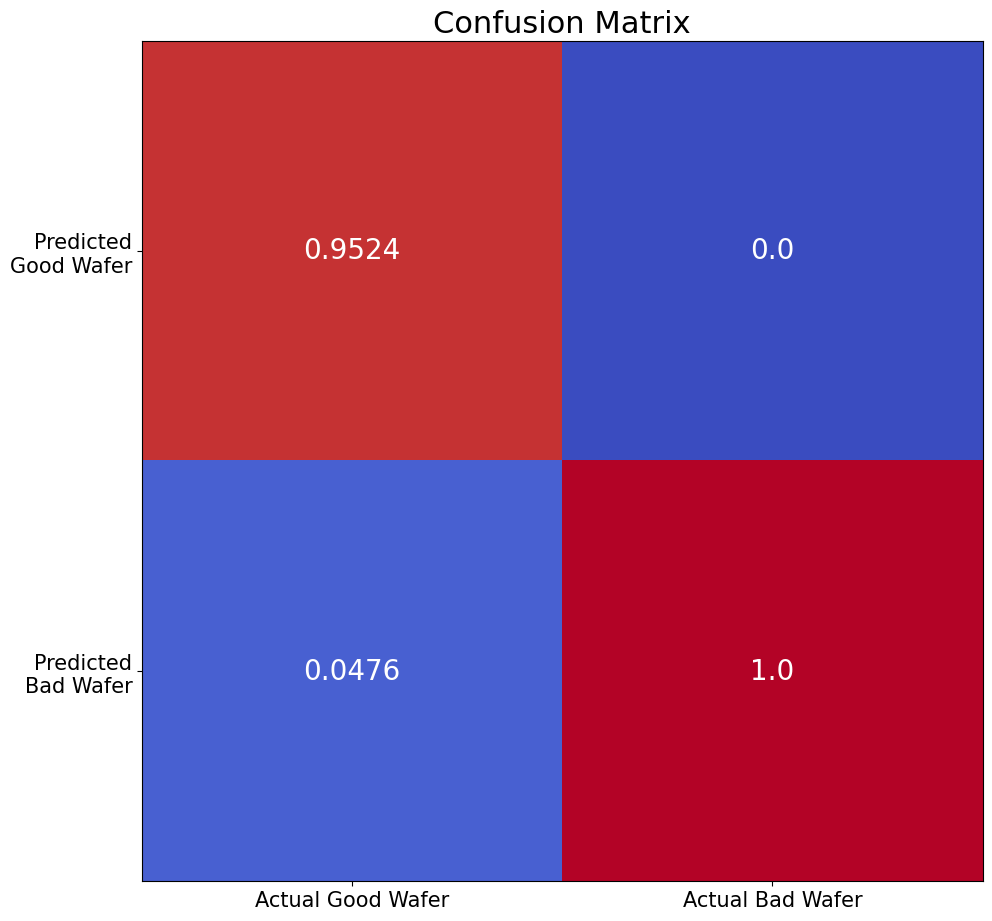

In [145]:
actualbad = resulttb[0:21]
actualgood = resulttb[21:42]

plot_latent(actualgood,actualbad)

latent_predicted_bad_wafer_data = resulttb[0:21]
latent_predicted_good_wafer_data = resulttb[21:42]

threshold_lower = good_mean - 2 * good_std
threshold_upper = good_mean + 2 * good_std

good_wafer_good_detection, good_wafer_bad_detection = classify(latent_predicted_good_wafer_data, threshold_lower, threshold_upper)
bad_wafer_good_detection, bad_wafer_bad_detection = classify(latent_predicted_bad_wafer_data, threshold_lower, threshold_upper)

total_bad_testing_data = len(latent_predicted_bad_wafer_data)
total_good_testing_data = len(latent_predicted_good_wafer_data)

table = np.array([
    ["",    "Actual Good Wafer", "Actual Bad Wafer"],
    ["Predicted Good Wafer", good_wafer_good_detection, bad_wafer_good_detection],
    ["Predicted Bad Wafer", good_wafer_bad_detection, bad_wafer_bad_detection]
])

# Display the table
print("\nConfusion Matrix:")
print("{:<40} {:<20} {:<20}".format(*table[0]))  # Header row
for row in table[1:]:
    print("{:<40} {:<20} {:<20}".format(*row))  # Data rows

confusion_matrix = np.array([
    [np.round(good_wafer_good_detection/total_good_testing_data,4), np.round(bad_wafer_good_detection/total_bad_testing_data,4)],  # Predicted Good: Actual Good, Actual Bad
    [np.round(good_wafer_bad_detection/total_good_testing_data,4), np.round(bad_wafer_bad_detection/total_bad_testing_data,4)]   # Predicted Bad: Actual Good, Actual Bad
])

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(confusion_matrix, cmap="coolwarm")

# Adding labels
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(["Actual Good Wafer", "Actual Bad Wafer"], fontsize=15)
ax.set_yticklabels(["Predicted\nGood Wafer", "Predicted\nBad Wafer"], fontsize=15)

# Rotating tick labels for better readability
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Adding text annotations with text wrapping
for i in range(2):
    for j in range(2):
        ax.text(j, i, str(confusion_matrix[i, j]), ha="center", va="center", color="white", fontsize=20)

# Title and display
ax.set_title("Confusion Matrix", fontsize=22)
plt.tight_layout()
plt.show()

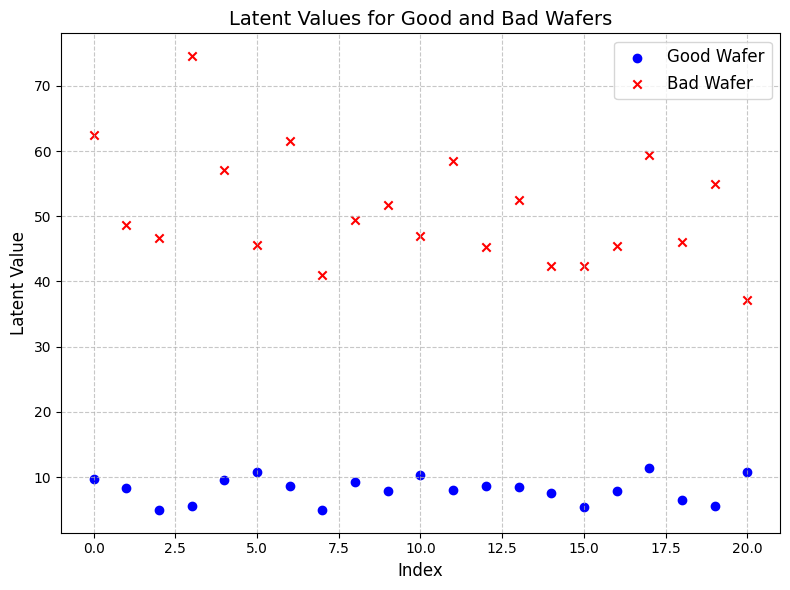

In [39]:
compare_bad = test_data(data_train[0:21])
compare_good = test_data(data_train[21:42])

# Plot latent values
plot_latent(compare_good, compare_bad)

In [39]:
max_shape = (40,40)
target_shape = (32,32)
train_max_row = 462 # Maximum data for training

strClass_trainTestLaebl_df = df[df['trainTestLabel'].apply(lambda x: isinstance(x, str))]
limited_df = sizeLimit_df(strClass_trainTestLaebl_df,max_shape,True)
training_df = limited_df[limited_df['trainTestLabel'] == 'Training']

bad_wafer_df = training_df[ (training_df['failureType'] != 'none')]
good_wafer_df = training_df[ (training_df['failureType'] == 'none')]

# Function to filter very bad data
def filter_condition(np_arr, wafer_type):
    count_0 = np.sum(np_arr == 0)  # Count occurrences of 1
    count_1 = np.sum(np_arr == 1)  # Count occurrences of 1
    count_2 = np.sum(np_arr == 2)  # Count occurrences of 2
    if wafer_type == 'bad': return (count_2 > 0.05 * count_1) & (count_0 < count_1)  # Check if count of 2 is less than 20% of count of 1
    else: return (count_2 < 0.05 * count_1) & (count_0 < count_1)  # Check if count of 2 is less than 20% of count of 1


bad_wafer_df = bad_wafer_df[bad_wafer_df['waferMap'].apply(lambda x: filter_condition(x, 'bad'))]
good_wafer_df = good_wafer_df[good_wafer_df['waferMap'].apply(lambda x: filter_condition(x, 'good'))]

# Label data for bad wafer
maxSize_bad_wafer = bad_wafer_df[(bad_wafer_df['waferMap'].apply(lambda x: x.shape == (35,36)))]
mtrx_label_bad_wafer = np.stack(maxSize_bad_wafer['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
mtrx_label_bad_wafer[(mtrx_label_bad_wafer == 1) | (mtrx_label_bad_wafer > 2)] = 2
base_bad_valid = np.array(mtrx_label_bad_wafer[0])
label_bad_wafer = np.tile(base_bad_valid,(train_max_row,1))

# Label data for good wafer
maxSize_good_wafer = good_wafer_df[(good_wafer_df['waferMap'].apply(lambda x: x.shape == (35,37)))]
mtrx_label_good_wafer = np.stack(maxSize_good_wafer['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
mtrx_label_good_wafer[mtrx_label_good_wafer >1] = 1
base_good_valid = np.array(mtrx_label_good_wafer[0])
label_good_wafer = np.tile(base_good_valid,(train_max_row,1))

# Maximum Data for Training
# print(bad_wafer_df.shape, good_wafer_df.shape)
max_training_good = good_wafer_df.shape[0]
max_training_bad = bad_wafer_df.shape[0]
print(max_training_good, max_training_bad)
bad_wafer_df = bad_wafer_df[:train_max_row]
good_wafer_df = good_wafer_df[:train_max_row]

print(len(good_wafer_df))
print(len(bad_wafer_df))
# Scale all image to asme dimension then flatten it to single row
data_bad_wafer = np.stack(bad_wafer_df['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
data_bad_wafer[data_bad_wafer>2] = 2

data_good_wafer = np.stack(good_wafer_df['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
data_good_wafer[data_good_wafer>2] = 2

label_train = np.concatenate((label_bad_wafer, label_good_wafer), axis=0)
data_train = np.concatenate((data_bad_wafer, data_good_wafer), axis=0)

label_train = np.where(label_train == 0, 0 , np.where(label_train == 1, 0.5, 1))
data_train = np.where(data_train == 0, 0 , np.where(data_train == 1, 0.5, 1))

print(label_train.shape)
print(data_train.shape)


106 8003
106
462
(924, 1024)
(568, 1024)


In [41]:
fnn1 = "..\\rtl_dev_teffandi\\input1.txt"
fnn2 = "..\\rtl_dev_teffandi\\input2.txt"
fnn3 = "..\\rtl_dev_teffandi\\input3.txt"
fnn4 = "..\\rtl_dev_teffandi\\input4.txt"


all_image_data_txt(data_train, fnn1, fnn2, fnn3, fnn4)

Good: 191
Bad: 377


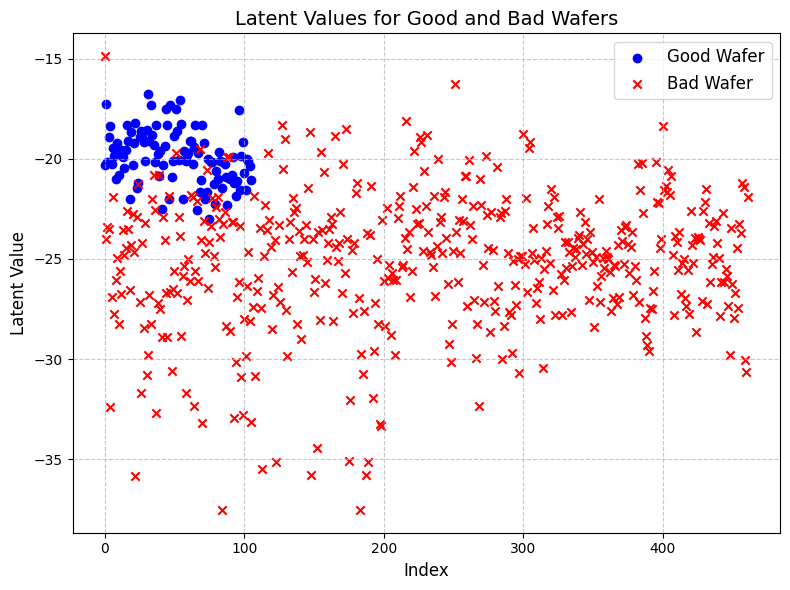


Confusion Matrix:
                                         Actual Good Wafer    Actual Bad Wafer    
Predicted Good Wafer                     102                  89                  
Predicted Bad Wafer                      4                    373                 


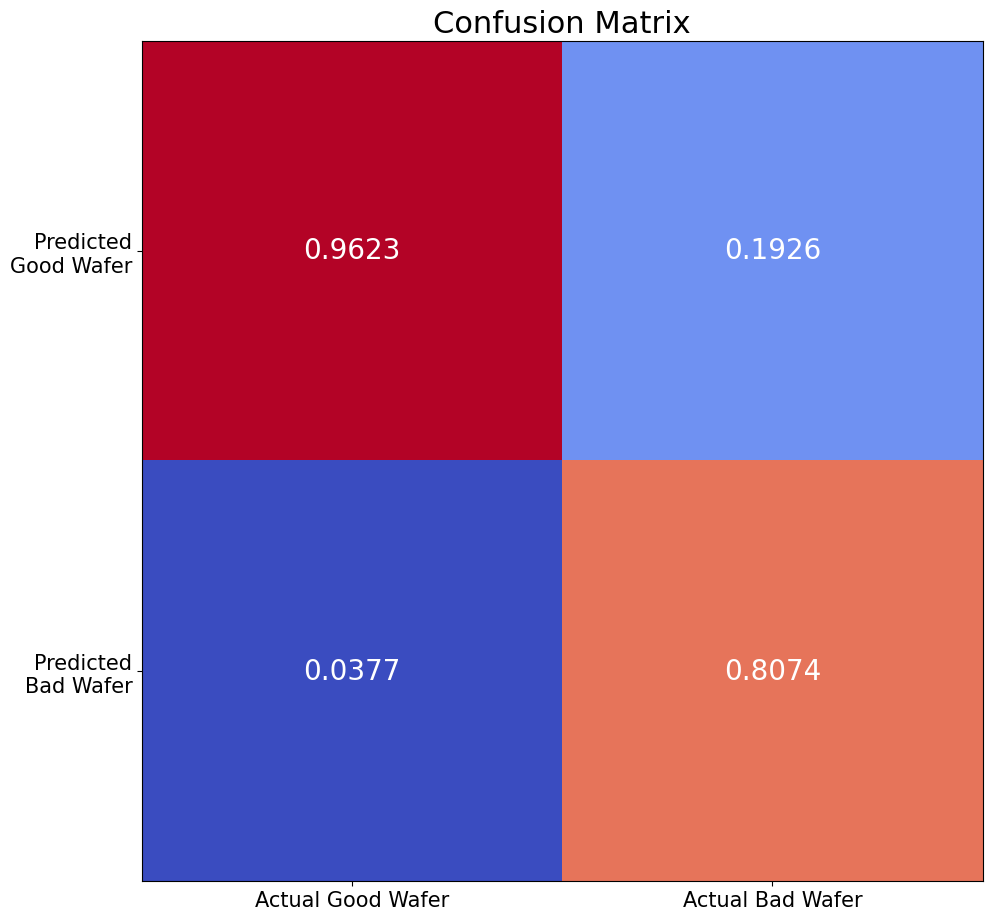

In [47]:
def plot_latent(good_latent,bad_latent):
    plt.figure(figsize=(8, 6))

    # Plot good wafers with 'o'
    plt.scatter(range(len(good_latent)), good_latent, marker='o', color='blue', label='Good Wafer')

    # Plot bad wafers with 'x'
    plt.scatter(range(len(bad_latent)), bad_latent, marker='x', color='red', label='Bad Wafer')

    # Adding labels, legend, and title
    plt.xlabel("Index", fontsize=12)
    plt.ylabel("Latent Value", fontsize=12)
    plt.title("Latent Values for Good and Bad Wafers", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Display the plot
    plt.tight_layout()
    plt.show()

result_tb = []
with open("data_tb\\result.txt", 'r') as file:
    for line in file:
        result_tb.append(fp_to_float(line.strip(),total_bits=16, frac_bits=8, input_format='hex'))
resulttb = np.array(result_tb)
# Compute mean and std for good wafer latent values
good_mean = np.mean(resulttb[462:568])
good_std = np.std(resulttb[462:568])

# Define thresholds
threshold_lower = good_mean - 2 * good_std
threshold_upper = good_mean + 2 * good_std
good, bad = classify(resulttb, threshold_lower, threshold_upper)
print("Good: " + str(good))
print("Bad: " + str(bad))

actualbad = resulttb[0:462]
actualgood = resulttb[462:568]

plot_latent(actualgood,actualbad)

latent_predicted_bad_wafer_data = resulttb[0:462]
latent_predicted_good_wafer_data = resulttb[462:568]

threshold_lower = good_mean - 2 * good_std
threshold_upper = good_mean + 2 * good_std

good_wafer_good_detection, good_wafer_bad_detection = classify(latent_predicted_good_wafer_data, threshold_lower, threshold_upper)
bad_wafer_good_detection, bad_wafer_bad_detection = classify(latent_predicted_bad_wafer_data, threshold_lower, threshold_upper)

total_bad_testing_data = len(latent_predicted_bad_wafer_data)
total_good_testing_data = len(latent_predicted_good_wafer_data)

table = np.array([
    ["",    "Actual Good Wafer", "Actual Bad Wafer"],
    ["Predicted Good Wafer", good_wafer_good_detection, bad_wafer_good_detection],
    ["Predicted Bad Wafer", good_wafer_bad_detection, bad_wafer_bad_detection]
])

# Display the table
print("\nConfusion Matrix:")
print("{:<40} {:<20} {:<20}".format(*table[0]))  # Header row
for row in table[1:]:
    print("{:<40} {:<20} {:<20}".format(*row))  # Data rows

confusion_matrix = np.array([
    [np.round(good_wafer_good_detection/total_good_testing_data,4), np.round(bad_wafer_good_detection/total_bad_testing_data,4)],  # Predicted Good: Actual Good, Actual Bad
    [np.round(good_wafer_bad_detection/total_good_testing_data,4), np.round(bad_wafer_bad_detection/total_bad_testing_data,4)]   # Predicted Bad: Actual Good, Actual Bad
])

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(confusion_matrix, cmap="coolwarm")

# Adding labels
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(["Actual Good Wafer", "Actual Bad Wafer"], fontsize=15)
ax.set_yticklabels(["Predicted\nGood Wafer", "Predicted\nBad Wafer"], fontsize=15)

# Rotating tick labels for better readability
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Adding text annotations with text wrapping
for i in range(2):
    for j in range(2):
        ax.text(j, i, str(confusion_matrix[i, j]), ha="center", va="center", color="white", fontsize=20)

# Title and display
ax.set_title("Confusion Matrix", fontsize=22)
plt.tight_layout()
plt.show()

In [2]:
# Testing Mean and Variance
def test_mean_variance(data_to_test):
    tested_mean = []
    tested_var = []
    for x in data_to_test:
        x = x.reshape(1, -1)
        _, miu, var, _, _, _ = vae.forward(x)
        tested_mean.append(miu)
        tested_var.append(var)
    return tested_mean, tested_var

test = [];
#k = 0
#for i in range(32*k):
#    test.append(0)
#for i in range(32):
#    test.append(1)
#for i in range(1024-32*(k+1)):
#    test.append(0)
for i in range(1024):
    test.append(1)
test1 = np.array([test])
print(test1)

_, mean, var, _, _, _ = vae.forward(test1)
print(mean)
print(var)

print("OutMean:")
print(float_to_fp(mean[0][0], total_bits=16, frac_bits=8, output_format='hex'))
print("OutVar:")
print(float_to_fp(var[0][0], total_bits=16, frac_bits=8, output_format='hex'))

_, _, W_mu, B_mu, W_var, B_var, _, _, _, _ = vae.get_train_param()
print("Bias:")
print(B_var[0][0])
print(float_to_fp(B_var[0][0], total_bits=16, frac_bits=8, output_format='hex'))
print("Mean:")
print(W_var[32][0])
#for i in range(len(W_var)):
#    print(float_to_fp(W_var[i][0], total_bits=16, frac_bits=8, output_format='hex'))

fn1 = "..\\rtl_dev_teffandi\\input_bad1.txt"
fn2 = "..\\rtl_dev_teffandi\\input_bad2.txt"
fn3 = "..\\rtl_dev_teffandi\\input_bad3.txt"
fn4 = "..\\rtl_dev_teffandi\\input_bad4.txt"

np_arr = test1[0]
db_np_arr = [np_arr, np_arr]
all_image_data_txt(db_np_arr, fn1, fn2, fn3, fn4)

print(float_to_fp(np.dot(test1, W_var)[0][0], total_bits=16, frac_bits=8, output_format='hex'))
print("Test dari PE0-3 CH1, cycle 8")
f = 896
a = np.dot([test1[0][f:f+8]], W_var[f:f+8])[0][0]
b = np.dot([test1[0][f+8:f+16]], W_var[f+8:f+16])[0][0]
c = np.dot([test1[0][f+16:f+24]], W_var[f+16:f+24])[0][0]
d = np.dot([test1[0][f+24:f+32]], W_var[f+24:f+32])[0][0]

print(float_to_fp(a, total_bits=16, frac_bits=8, output_format='hex'))


print(float_to_fp(b, total_bits=16, frac_bits=8, output_format='hex'))
print(float_to_fp(c, total_bits=16, frac_bits=8, output_format='hex'))
print(float_to_fp(d, total_bits=16, frac_bits=8, output_format='hex'))
print("Out PE:")
print(float_to_fp(a+b+c+d, total_bits=16, frac_bits=8, output_format='hex'))
print("Out Array:")
print(float_to_fp(a+b+c+d+B_var[0][0], total_bits=16, frac_bits=8, output_format='hex'))

NameError: name 'np' is not defined

In [75]:
print(test1[0][0:8][0])
i = 8
print(float_to_fp(W_var[i-1:i][0][0], total_bits=16, frac_bits=8, output_format='hex'))

1
0005


In [68]:
for i in range(len(W_var)):
    print(float_to_fp(W_var[i][0], total_bits=16, frac_bits=8, output_format='hex'))


0001
0003
ffff
ffff
0004
0002
0003
0005
0000
0003
0001
0004
fffe
fffb
fff2
fff0
fff1
fff4
fffa
0000
fffd
0008
0003
fffe
fffd
0002
ffff
0007
0001
ffff
0001
0005
fffe
0002
fffe
0001
ffff
0003
0003
0000
0003
0000
fff5
fff8
fff2
fff4
fff3
fff7
fff7
fffa
fff4
fff8
fffc
fff7
fff9
ffff
0000
0000
0006
0006
fffc
ffff
fffc
ffff
0003
0000
0000
ffff
0004
0003
0002
fffc
fff6
fff7
fff9
fff3
fffa
fff7
fff9
fff5
ffee
fffb
fff5
fff6
fff4
fff9
fff4
fff7
fffc
ffff
0000
0001
0003
0004
fffc
fffe
fffd
0001
0000
0000
0004
fffd
fffa
fff6
fff7
fff6
fff7
fff8
fff6
fff4
fff5
fff4
fff5
fff7
fff7
fff8
fff9
fff6
fffa
fff7
fff7
fff6
fffd
0003
0000
fffd
fffe
0001
0002
0001
ffff
0001
0001
fff5
fff3
fffa
fff8
fff6
fff5
fff7
fff2
fff0
fff6
fff3
fff0
fff6
fff7
fff7
fff4
fffa
fff7
fff4
fff8
fffa
fff4
ffff
fffd
0002
0000
0000
0006
fffd
0000
0000
fff5
fff7
fff6
fff4
fff3
fffd
fff8
fff9
fffd
fff5
fff6
fff2
fff8
fff1
fff7
fff3
fff5
fff9
fff6
fff4
fff3
fff6
fff6
fffc
0002
ffff
0001
0002
0000
0000
fffe
fffb
fff5
fff8
fff4
fff6


In [94]:
print(float_to_fp(np.dot([test1[0][6:8]], W_var[6:8])[0][0], total_bits=16, frac_bits=8, output_format='hex'))
j = 7
x = np.dot([test1[0][j-1:j+128]], W_var[j-1:j+128])[0][0]
y1 = np.dot([test1[0][j-1:j]], W_var[j-1:j])[0][0]
y2 = np.dot([test1[0][j:j+1]], W_var[j:j+1])[0][0]
print(y1)
print(float_to_fp(y1, total_bits=16, frac_bits=8, output_format='hex'))
print(y2)
print(float_to_fp(y2, total_bits=16, frac_bits=8, output_format='hex'))
print(y1+y2)
print(float_to_fp(y1+y2, total_bits=16, frac_bits=8, output_format='hex'))

print("Loop:")
for k in range(8):
    x1 = np.dot([test1[0][(k)*128:(k+1)*128]], W_var[(k)*128:(k+1)*128])[0][0]
    print(x1)
    print(float_to_fp(x1, total_bits=16, frac_bits=8, output_format='hex'))

0007
0.010288554190905823
0003
0.018160422450398058
0005
0.02844897664130388
0007
Loop:
-1.8895603468695492
fe1c
-3.690315541185359
fc4f
-4.4987517399910955
fb80
-4.709216223172115
fb4a
-4.741580420813715
fb42
-4.294665494109318
fbb5
-3.5088015450022407
fc7e
-2.3953382633389495
fd9b
